<a href="https://colab.research.google.com/github/paradox20029/computational_intelligence/blob/main/SIT_215_TASK1_4_annoted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time
import heapq

class Graph:
    """
    Represents a graph data structure using an adjacency list representation.

    Attributes:
        graph_dict (dict): A dictionary where keys represent nodes and values are dictionaries
                           of connected nodes and their associated edge distances.
        directed (bool): True if the graph is directed, False if undirected. Defaults to True.
    """
    def __init__(self, graph_dict=None, directed=True):
        """
        Initializes a new Graph object.

        Args:
            graph_dict (dict, optional): A dictionary representing the graph structure.
                                         Defaults to an empty dictionary.
            directed (bool, optional): True for a directed graph, False for undirected.
                                       Defaults to True.
        """
        # Use the provided graph_dict or an empty dictionary if None
        self.graph_dict = graph_dict or {}
        self.directed = directed

        # If undirected, make the graph connections bidirectional
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """
        Converts the graph to undirected by adding reverse edges for each existing edge.
        """
        # Iterate through nodes and their connections
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                # Add a reverse edge if it doesn't already exist
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """
        Adds an edge between nodes A and B with the given distance.

        Args:
            A: The starting node.
            B: The ending node.
            distance (int, optional): The distance or weight of the edge. Defaults to 1.
        """
        # Add the edge from A to B
        self.connect1(A, B, distance)
        # If undirected, also add an edge from B to A
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """
        Adds a directed edge from node A to node B with the given distance.

        Args:
            A: The starting node.
            B: The ending node.
            distance (int): The distance or weight of the edge.
        """
        # Use setdefault to create a dictionary for node A if it doesn't exist
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """
        Retrieves connections from a node.

        Args:
            a: The node to get connections from.
            b (optional): If provided, returns the distance between nodes a and b.

        Returns:
            dict or int: If b is None, returns a dictionary of connections from node a.
                         If b is provided, returns the distance between nodes a and b
                         (or None if no connection exists).
        """
        # Get the connections dictionary for node a
        links = self.graph_dict.setdefault(a, {})
        # If b is not provided, return the entire connections dictionary
        if b is None:
            return links
        # If b is provided, return the distance between a and b
        else:
            return links.get(b)

    def nodes(self):
        """
        Returns a list of all nodes in the graph.

        Returns:
            list: A list of all nodes in the graph.
        """
        # Get all nodes that are keys in the graph_dict
        s1 = set([k for k in self.graph_dict.keys()])
        # Get all nodes that are connected to any node (values in the graph_dict)
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        # Combine the two sets to get all unique nodes
        nodes = s1.union(s2)
        return list(nodes)

def UndirectedGraph(graph_dict=None):
    """
    Creates and returns an undirected Graph object.

    Args:
        graph_dict (dict, optional): A dictionary representing the graph structure.
                                     Defaults to None.

    Returns:
        Graph: An undirected Graph object.
    """
    # Call the Graph constructor with directed=False to create an undirected graph
    return Graph(graph_dict=graph_dict, directed=False)

In [2]:

class Problem(object):
    """
    A base class for defining search problems.

    Attributes:
        initial: The initial state of the problem.
        goal: The desired goal state (can be a single state or a list of states).
    """

    def __init__(self, initial, goal=None):
        """
        Initializes a new Problem instance.

        Args:
            initial: The starting state of the problem.
            goal: The target state(s) to reach.
                  Defaults to None, indicating no specific goal.
        """
        self.initial = initial  # Store the initial state
        self.goal = goal  # Store the goal state(s)

    def actions(self, state):
        """
        Returns the actions that can be executed in the given state.

        This method needs to be implemented by subclasses.

        Args:
            state: The current state of the problem.

        Raises:
            NotImplementedError: This method is abstract and must be
                                 implemented by subclasses.
        """
        raise NotImplementedError  # Indicate that this method must be overridden

    def result(self, state, action):
        """
        Returns the state that results from executing the given action in the given state.

        This method needs to be implemented by subclasses.

        Args:
            state: The current state of the problem.
            action: The action to execute.

        Raises:
            NotImplementedError: This method is abstract and must be
                                 implemented by subclasses.
        """
        raise NotImplementedError  # Indicate that this method must be overridden

    def goal_test(self, state):
        """
        Checks if the given state is a goal state.

        Args:
            state: The state to check.

        Returns:
            bool: True if the state is a goal state, False otherwise.
        """
        if isinstance(self.goal, list):  # Check if goal is a list of states
            return any(x == state for x in self.goal)  # Check if state is in the goal list
        else:
            return state == self.goal  # Check if state equals the single goal state

    def path_cost(self, c, state1, action, state2):
        """
        Returns the cost of a path that arrives at state2 from state1 via action,
        assuming cost c to get up to state1.

        In this base implementation, the cost is simply incremented by 1 for each action.

        Args:
            c: The cost to reach state1.
            state1: The previous state.
            action: The action taken.
            state2: The resulting state.

        Returns:
            int: The total path cost.
        """
        return c + 1  # Increment the cost by 1 for each action

In [3]:
class Node:
    """
    Represents a node in a search tree. Contains a state, parent node,
    action that led to this state, and the path cost to reach this state.
    """
    def __init__(self, state, parent=None, action=None, path_cost=0):
        """
        Initializes a new Node object.

        Args:
            state: The state represented by this node.
            parent (Node, optional): The parent node. Defaults to None.
            action: The action that led to this state. Defaults to None.
            path_cost (int, optional): The cost to reach this state. Defaults to 0.
        """
        self.state = state  # The state represented by this node
        self.parent = parent  # The parent node in the search tree
        self.action = action  # The action that led to this state
        self.path_cost = path_cost  # The total cost to reach this node
        self.depth = 0  # The depth of this node in the search tree
        if parent:
            self.depth = parent.depth + 1  # Calculate depth based on parent

    def __repr__(self):
        """Returns a string representation of the Node."""
        return "<Node {}>".format(self.state)  # Format: <Node state>

    def __lt__(self, node):
        """Compares two nodes based on their states."""
        return self.state < node.state  # Used for sorting in priority queues

    def expand(self, problem):
        """
        Generates child nodes by applying possible actions to the current state.

        Args:
            problem (Problem): The problem definition.

        Returns:
            list: A list of child nodes.
        """
        return [self.child_node(problem, action)  # Create child nodes for each action
                for action in problem.actions(self.state)]  # Get possible actions

    def child_node(self, problem, action):
        """
        Creates a new child node by applying an action to the current state.

        Args:
            problem (Problem): The problem definition.
            action: The action to apply.

        Returns:
            Node: The new child node.
        """
        next_state = problem.result(self.state, action)  # Get the next state
        next_node = Node(next_state, self, action,  # Create a new Node object
                         problem.path_cost(self.path_cost, self.state,  # Update path cost
                                           action, next_state))
        return next_node  # Return the new child node

    def solution(self):
        """Returns the sequence of actions that led to this node."""
        return [node.action for node in self.path()[1:]]  # Get actions from the path

    def path(self):
        """
        Reconstructs the path from the initial state to this node.

        Returns:
            list: A list of nodes representing the path.
        """
        node, path_back = self, []  # Start with current node and empty path
        while node:  # While there's a node to trace back
            path_back.append(node)  # Add the current node to the path
            node = node.parent  # Move to the parent node
        return list(reversed(path_back))  # Reverse the path to get correct order

    def __eq__(self, other):
        """Checks if two nodes are equal (based on their states)."""
        return isinstance(other, Node) and self.state == other.state  # Compare states

    def __hash__(self):
        """Returns a hash value for the node, based on its state."""
        return hash(self.state)  # Enables using nodes in sets/dictionaries

In [4]:
class WheelchairProblem(Problem):
    def __init__(self, initial, goal, graph):
        super().__init__(initial, goal)
        self.graph = graph
        self.infinity = math.inf

    def actions(self, A):
        """Return neighboring locations accessible from the current state."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """Move to the neighboring location specified by the action."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        """Calculate path cost, considering accessibility features."""
        return cost_so_far + (self.graph.get(A, B) or self.infinity)

    def h(self, node):
        """Heuristic: Euclidean distance to goal for A* search."""
        locs = self.graph.locations
        if locs:
            if isinstance(node, str):
                return int(self.distance(locs[node], locs[self.goal]))
            return int(self.distance(locs[node.state], locs[self.goal]))
        return self.infinity

    def distance(self, a, b):
        """Calculate Euclidean distance between two coordinates."""
        xA, yA = a
        xB, yB = b
        return np.hypot((xA - xB), (yA - yB))

In [5]:
wheelchair_map = UndirectedGraph(dict(
    ME=dict(P1=100, KR1=50, L=200),  # Main Entrance
    P1=dict(ME=100, KR1=40, SE=120), # Pathway 1
    KR1=dict(ME=50, P1=40, J1=60),  # Kerb Ramp 1
    L=dict(ME=200, KR2=60, C=140, S=300),  # Library (steep slope to S)
    C=dict(L=140, A=160, R1=60, LF2=100),  # Cafe
    S=dict(L=300, A=240, LF1=80),          # Study Area
    A=dict(S=240, KR3=50, C=160),          # Admin Building
    KR2=dict(L=60, J1=80),                 # Kerb Ramp 2
    J1=dict(KR1=60, KR2=80, CY=70),        # Junction 1
    CY=dict(J1=70, J2=90),                 # Courtyard
    J2=dict(CY=90, AD=120),                # Junction 2
    AD=dict(J2=120, P2=100),               # Academic Department
    P2=dict(AD=100, KR4=30),               # Pathway 2
    KR3=dict(A=50),                        # Kerb Ramp 3
    KR4=dict(P2=30),                       # Kerb Ramp 4
    LF1=dict(S=80),                        # Lift 1
    LF2=dict(C=100, R2=40),                # Lift 2
    R1=dict(C=60),                         # Restroom 1 (Goal)
    R2=dict(LF2=40),                       # Restroom 2
    SE=dict(P1=120)                        # Side Entrance
))

wheelchair_map.locations = dict(
    ME=(0, 0),          # Main Entrance at origin
    P1=(100, 0),        # Pathway 1, further right
    KR1=(50, 50),       # Kerb Ramp 1, positioned between ME and P1 but offset
    L=(200, 0),         # Library, further right from ME
    C=(150, 100),       # Cafe, central but higher
    S=(300, 150),       # Study Area, further right and up
    A=(0, 200),         # Admin Building, left and higher
    R1=(200, 150),      # Restroom 1, near Cafe but distinct
    LF1=(350, 200),     # Lift 1, near Study Area
    AD=(400, 300),      # Academic Department, far right and up
    J1=(100, 100),      # Junction 1, central
    J2=(300, 250),      # Junction 2, near AD
    CY=(200, 200),      # Courtyard, central but higher
    KR2=(250, 50),      # Kerb Ramp 2, near Library
    KR3=(50, 250),      # Kerb Ramp 3, near Admin Building
    KR4=(450, 350),     # Kerb Ramp 4, near P2
    LF2=(250, 100),     # Lift 2, near Cafe
    R2=(300, 100),      # Restroom 2, near Lift 2
    SE=(150, -50),      # Side Entrance, below P1
    P2=(400, 350)       # Pathway 2, near AD
)

# Define the problem: Navigate from Main Entrance (ME) to Restroom 1 (R1)
wheelchair_problem = WheelchairProblem('ME', 'R1', wheelchair_map)

In [6]:



import pandas as pd  # Import the pandas library for data manipulation (DataFrames)
import numpy as np  # Import the numpy library for numerical operations (arrays)

def create_adjacency_matrix(graph):
    """
    Creates an adjacency matrix representation of the given graph.

    Args:
        graph (Graph): The graph object to create the adjacency matrix from.

    Returns:
        tuple: A tuple containing the adjacency matrix as a pandas DataFrame
               and a list of node names.
    """
    nodes = sorted(graph.nodes())  # Get a sorted list of all nodes in the graph
    n = len(nodes)  # Get the number of nodes
    matrix = np.full((n, n), float('inf'))  # Create an n x n matrix, initialize with infinity
    np.fill_diagonal(matrix, 0)  # Set diagonal elements to 0 (distance from a node to itself)

    # Iterate through each node and its connections
    for i, node1 in enumerate(nodes):  # Loop through each node (node1) with its index (i)
        for node2, cost in graph.get(node1).items():  # Loop through connected nodes (node2) and edge costs
            j = nodes.index(node2)  # Get the index (j) of the connected node (node2)
            matrix[i][j] = cost  # Set the cost in the matrix at (i, j)
            matrix[j][i] = cost  # Set the cost in the matrix at (j, i) (undirected graph)

    # Convert the matrix to a pandas DataFrame for better display
    df = pd.DataFrame(matrix, index=nodes, columns=nodes)  # Create DataFrame with node names as index and columns

    # Replace infinity values with '-' for readability
    df = df.replace(float('inf'), '-')  # Replace 'inf' with '-'

    return df, nodes  # Return the DataFrame and the list of nodes

# Create and print the adjacency matrix for the wheelchair_map
adj_matrix_df, node_list = create_adjacency_matrix(wheelchair_map)  # Call the function with the graph
print("Adjacency Matrix:")  # Print a header
print(adj_matrix_df)  # Print the adjacency matrix DataFrame

Adjacency Matrix:
         A     AD      C    CY    J1     J2   KR1   KR2   KR3   KR4      L  \
A      0.0      -  160.0     -     -      -     -     -  50.0     -      -   
AD       -    0.0      -     -     -  120.0     -     -     -     -      -   
C    160.0      -    0.0     -     -      -     -     -     -     -  140.0   
CY       -      -      -   0.0  70.0   90.0     -     -     -     -      -   
J1       -      -      -  70.0   0.0      -  60.0  80.0     -     -      -   
J2       -  120.0      -  90.0     -    0.0     -     -     -     -      -   
KR1      -      -      -     -  60.0      -   0.0     -     -     -      -   
KR2      -      -      -     -  80.0      -     -   0.0     -     -   60.0   
KR3   50.0      -      -     -     -      -     -     -   0.0     -      -   
KR4      -      -      -     -     -      -     -     -     -   0.0      -   
L        -      -  140.0     -     -      -     -  60.0     -     -    0.0   
LF1      -      -      -     -     -      -   

In [7]:


def print_direct_connections(graph):
    """
    Prints the direct connections (edges) of the graph along with their costs.

    Args:
        graph (Graph): The graph object.
    """
    nodes = sorted(graph.nodes())  # Get a sorted list of all nodes in the graph
    print("\nDirect Connections (Edges):")  # Print a header for the connections
    connections = []  # Initialize an empty list to store connections

    # Iterate through each node and its neighbors to find connections
    for node1 in nodes:  # Loop through each node (node1)
        for node2, cost in graph.get(node1).items():  # Get the neighbors (node2) and edge costs (cost)
            if node1 < node2:  # Avoid duplicates by only considering edges in one direction (undirected graph)
                connections.append(f"{node1} -- {node2}: {cost}m")  # Add connection and cost to the list

    # Print the connections, sorted alphabetically
    for conn in sorted(connections):  # Loop through the sorted connections list
        print(conn)  # Print each connection

# Print direct connections of the wheelchair_map
print_direct_connections(wheelchair_map)  # Call the function with the wheelchair_map graph


Direct Connections (Edges):
A -- C: 160m
A -- KR3: 50m
A -- S: 240m
AD -- J2: 120m
AD -- P2: 100m
C -- L: 140m
C -- LF2: 100m
C -- R1: 60m
CY -- J1: 70m
CY -- J2: 90m
J1 -- KR1: 60m
J1 -- KR2: 80m
KR1 -- ME: 50m
KR1 -- P1: 40m
KR2 -- L: 60m
KR4 -- P2: 30m
L -- ME: 200m
L -- S: 300m
LF1 -- S: 80m
LF2 -- R2: 40m
ME -- P1: 100m
P1 -- SE: 120m


In [8]:


def a_star_search(problem):
    """
    Performs A* search to find a path from the initial state to the goal state.

    Args:
        problem (Problem): The search problem instance.

    Returns:
        Node: The goal node if a path is found, otherwise None.
    """
    node = Node(problem.initial)  # Create the starting node with the initial state
    frontier = [(problem.h(node), node)]  # Initialize the frontier (priority queue) with the starting node and its heuristic value
    explored = set()  # Keep track of explored states to avoid cycles
    g_scores = {problem.initial: 0}  # Store the cost to reach each node from the start (g-score)
    f_scores = {problem.initial: problem.h(node)}  # Store the estimated total cost (f-score = g-score + heuristic)

    while frontier:  # While there are nodes in the frontier
        _, current = heapq.heappop(frontier)  # Get the node with the lowest f-score from the frontier
        if problem.goal_test(current.state):  # Check if the current node's state is the goal state
            return current  # If it is the goal state, return the node (path found)

        explored.add(current.state)  # Mark the current node's state as explored

        # Explore neighboring nodes (possible actions from the current state)
        for action in problem.actions(current.state):
            child = current.child_node(problem, action)  # Create a child node by applying the action
            tentative_g = g_scores[current.state] + problem.path_cost(0, current.state, action, child.state)  # Calculate the tentative g-score for the child

            # Check if the child node has already been explored with a lower or equal cost
            if child.state in explored and tentative_g >= g_scores.get(child.state, float('inf')):
                continue  # Skip this child node if it's already explored with a better path

            # Update g-score and f-score if a better path to the child is found
            if child.state not in g_scores or tentative_g < g_scores[child.state]:
                g_scores[child.state] = tentative_g  # Update g-score
                f_scores[child.state] = tentative_g + problem.h(child)  # Update f-score
                heapq.heappush(frontier, (f_scores[child.state], child))  # Add the child to the frontier with its f-score

    return None  # If the frontier is empty and the goal hasn't been found, there's no path

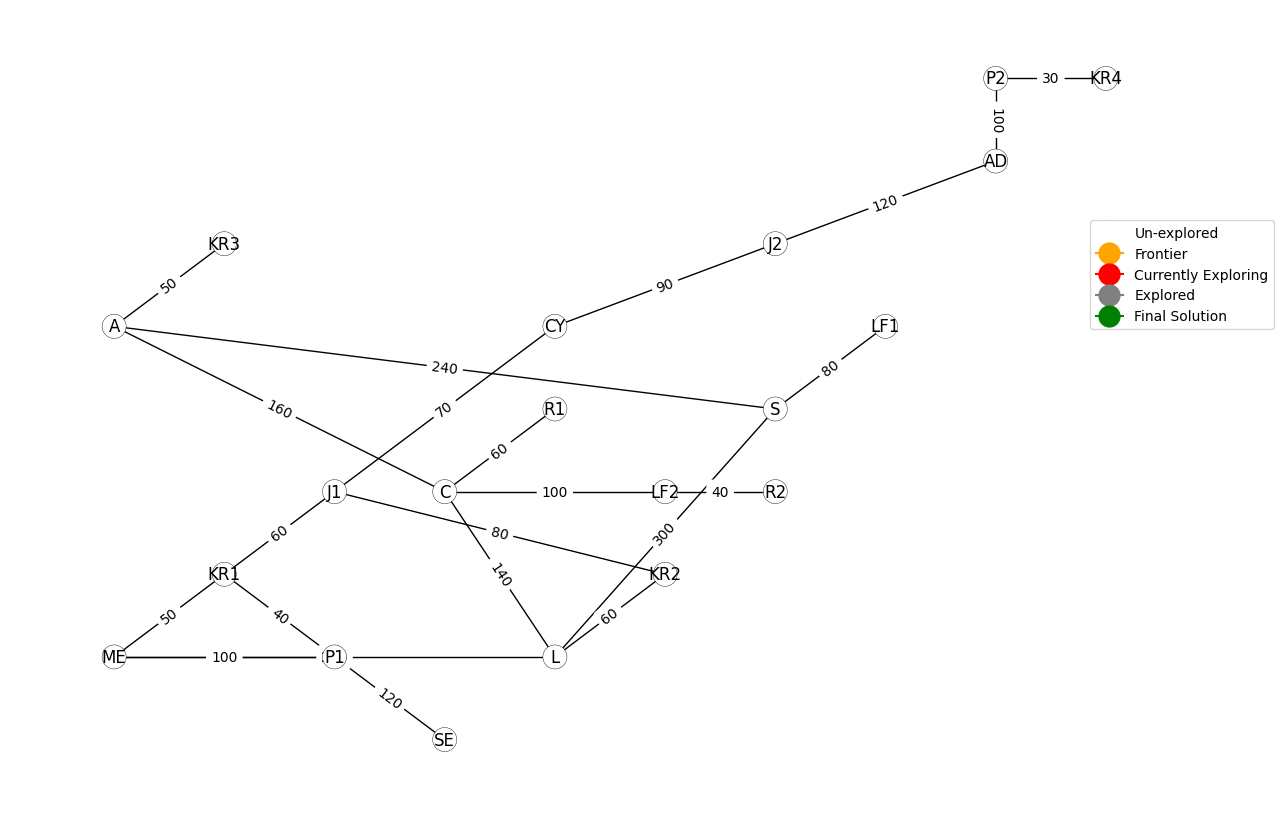

In [9]:

# Visualization data
# Initialize all nodes to white color
node_colors = {node: 'white' for node in wheelchair_map.locations.keys()}
# Get node positions from the wheelchair_map
node_positions = wheelchair_map.locations
# Calculate node label positions (slightly below the node)
node_label_pos = {k: [v[0], v[1] - 20] for k, v in wheelchair_map.locations.items()}
# Get edge weights from the graph_dict
edge_weights = {(k, k2): v2 for k, v in wheelchair_map.graph_dict.items() for k2, v2 in v.items()}

# Store all visualization data in a dictionary
wheelchair_graph_data = {
    'graph_dict': wheelchair_map.graph_dict,  # Graph structure
    'node_colors': node_colors,               # Colors for nodes
    'node_positions': node_positions,         # Positions of nodes
    'node_label_positions': node_label_pos,   # Positions for node labels
    'edge_weights': edge_weights              # Weights of edges
}

# Import necessary libraries for visualization
import networkx as nx  # For graph manipulation
import matplotlib.pyplot as plt  # For plotting
from matplotlib import lines  # For creating legend elements

def show_wheelchair_map(graph_data, node_colors=None):
    """
    Displays the wheelchair accessibility map using networkx and matplotlib.

    Args:
        graph_data (dict): Dictionary containing graph structure and visualization data.
        node_colors (dict, optional): Dictionary of node colors. Defaults to None.
    """
    # Create a networkx graph object from the graph_dict
    G = nx.Graph(graph_data['graph_dict'])

    # Extract data from graph_data
    node_colors = node_colors or graph_data['node_colors']  # Use provided colors or default
    node_positions = graph_data['node_positions']
    node_label_pos = graph_data['node_label_positions']
    edge_weights = graph_data['edge_weights']

    # Set up the plot
    plt.figure(figsize=(12, 8))  # Create a figure with a specific size

    # Draw the graph with nodes
    nx.draw(G, pos=node_positions,  # Use node positions for layout
            node_color=[node_colors[node] for node in G.nodes()],  # Set node colors
            linewidths=0.3, edgecolors='k', with_labels=True)  # Style edges and labels

    # Draw edge labels (weights)
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=10)

    # Create legend elements
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=15, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")

    # Add a legend to the plot
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Explored', 'Final Solution'),
               numpoints=1, prop={'size': 10}, loc=(0.9, 0.6))

    # Display the plot
    plt.show()

    # This part seems redundant as it redefines wheelchair_graph_data, which is already defined
    # It's likely left over from previous code iterations and doesn't affect the functionality
    wheelchair_graph_data = {
    'graph_dict': wheelchair_map.graph_dict,
    'node_colors': node_colors,
    'node_positions': node_positions,
    'node_label_positions': node_label_pos,
    'edge_weights': edge_weights
}

# Call the function to display the map
show_wheelchair_map(wheelchair_graph_data)



In [10]:


# Test 1: ME to R1
problem1 = WheelchairProblem('ME', 'R1', wheelchair_map)  # Define a problem: find path from 'ME' to 'R1' using the wheelchair_map
result1 = a_star_search(problem1)  # Solve the problem using the A* search algorithm
path1 = result1.path() if result1 else []  # Get the path from the result (if found), otherwise an empty list
print("Test 1: Path from ME to R1:", [node.state for node in path1])  # Print the path (list of node states)
print("Path Cost:", result1.path_cost if result1 else "No path found")  # Print the total cost of the path

# Test 2: A to LF1
problem2 = WheelchairProblem('A', 'LF1', wheelchair_map)  # Define another problem: find path from 'A' to 'LF1'
result2 = a_star_search(problem2)  # Solve this problem using A* search
path2 = result2.path() if result2 else []  # Get the path from the result (if found), otherwise an empty list
print("Test 2: Path from A to LF1:", [node.state for node in path2])  # Print the path (list of node states)
print("Path Cost:", result2.path_cost if result2 else "No path found")  # Print the total cost of the path

# Test 3: SE to AD
problem3 = WheelchairProblem('SE', 'AD', wheelchair_map)  # Define a third problem: find path from 'SE' to 'AD'
result3 = a_star_search(problem3)  # Solve this problem using A* search
path3 = result3.path() if result3 else []  # Get the path from the result (if found), otherwise an empty list
print("Test 3: Path from SE to AD:", [node.state for node in path3])  # Print the path (list of node states)
print("Path Cost:", result3.path_cost if result3 else "No path found")  # Print the total cost of the path

Test 1: Path from ME to R1: ['ME', 'L', 'C', 'R1']
Path Cost: 400
Test 2: Path from A to LF1: ['A', 'S', 'LF1']
Path Cost: 320
Test 3: Path from SE to AD: ['SE', 'P1', 'KR1', 'J1', 'CY', 'J2', 'AD']
Path Cost: 500


Visualizing Test 1: ME to R1


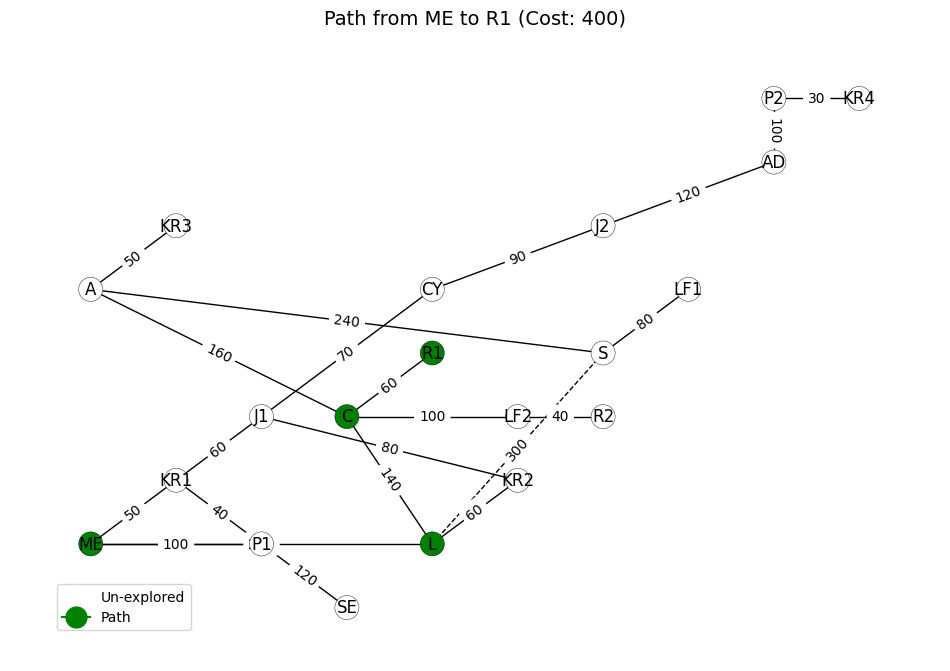

Visualizing Test 2: A to LF1


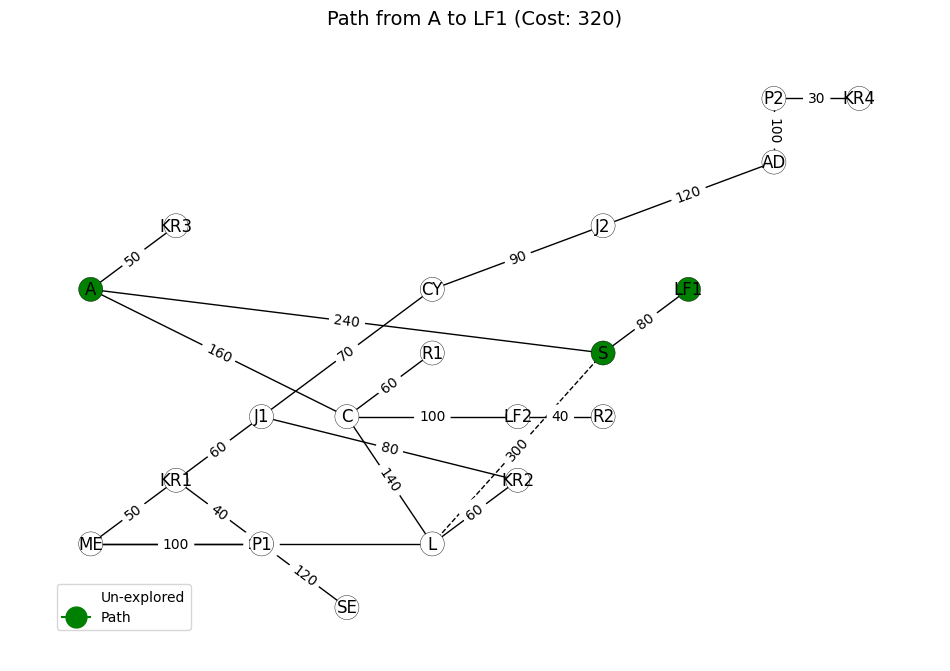

Visualizing Test 3: SE to AD


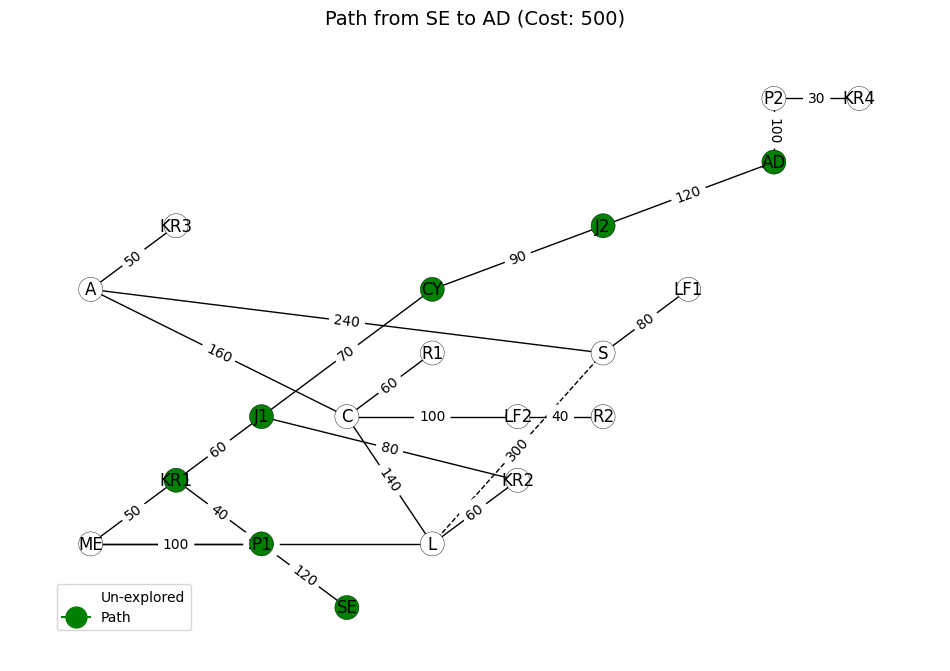

In [11]:

def show_path(graph_data, path, start_node=None, end_node=None, cost=None):
    """
    Visualizes the path on the wheelchair map with optional title information.

    Args:
        graph_data (dict): Dictionary containing graph structure and visualization data.
        path (list): List of Node objects representing the path.
        start_node (str, optional): Starting node of the path. Defaults to None.
        end_node (str, optional): Ending node of the path. Defaults to None.
        cost (int or float, optional): Total path cost to display in the title.
    """
    # Create a NetworkX graph object from the graph data
    G = nx.Graph(graph_data['graph_dict'])

    # Set all nodes to white initially
    node_colors = {node: 'white' for node in G.nodes()}

    # Highlight nodes in the path with green color
    for node in path:
        node_colors[node.state] = 'green'

    # Get node positions and edge weights
    node_positions = graph_data['node_positions']
    edge_weights = graph_data['edge_weights']

    # Create a Matplotlib figure for the plot
    plt.figure(figsize=(12, 8))

    # Title includes start, end, and cost if provided
    title = "Wheelchair Navigation Path"
    if start_node and end_node:
        title = f"Path from {start_node} to {end_node}"
        if cost is not None:
            title += f" (Cost: {cost})"
    plt.title(title, fontsize=14, pad=15)

    # Define edge styles (dashed for steep slopes)
    edge_styles = ['dashed' if edge in [('L', 'S'), ('S', 'L')] else 'solid' for edge in G.edges()]

    # Draw the graph
    nx.draw(
        G, pos=node_positions,
        node_color=[node_colors[node] for node in G.nodes()],
        linewidths=0.3, edgecolors='k',
        with_labels=True, style=edge_styles
    )

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=10)

    # Create legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    plt.legend((white_circle, green_circle), ('Un-explored', 'Path'), numpoints=1, prop={'size': 10}, loc=(0.05, 0.05))

    plt.show()

print("Visualizing Test 1: ME to R1")
show_path(wheelchair_graph_data, path1, start_node="ME", end_node="R1", cost=result1.path_cost)

print("Visualizing Test 2: A to LF1")
show_path(wheelchair_graph_data, path2, start_node="A", end_node="LF1", cost=result2.path_cost)

print("Visualizing Test 3: SE to AD")
show_path(wheelchair_graph_data, path3, start_node="SE", end_node="AD", cost=result3.path_cost)



Available nodes: ['A', 'AD', 'C', 'CY', 'J1', 'J2', 'KR1', 'KR2', 'KR3', 'KR4', 'L', 'LF1', 'LF2', 'ME', 'P1', 'P2', 'R1', 'R2', 'S', 'SE']
Enter the starting node: A
Enter the ending node: AD
Path from A to AD: ['A', 'C', 'L', 'KR2', 'J1', 'CY', 'J2', 'AD']
Path Cost: 720


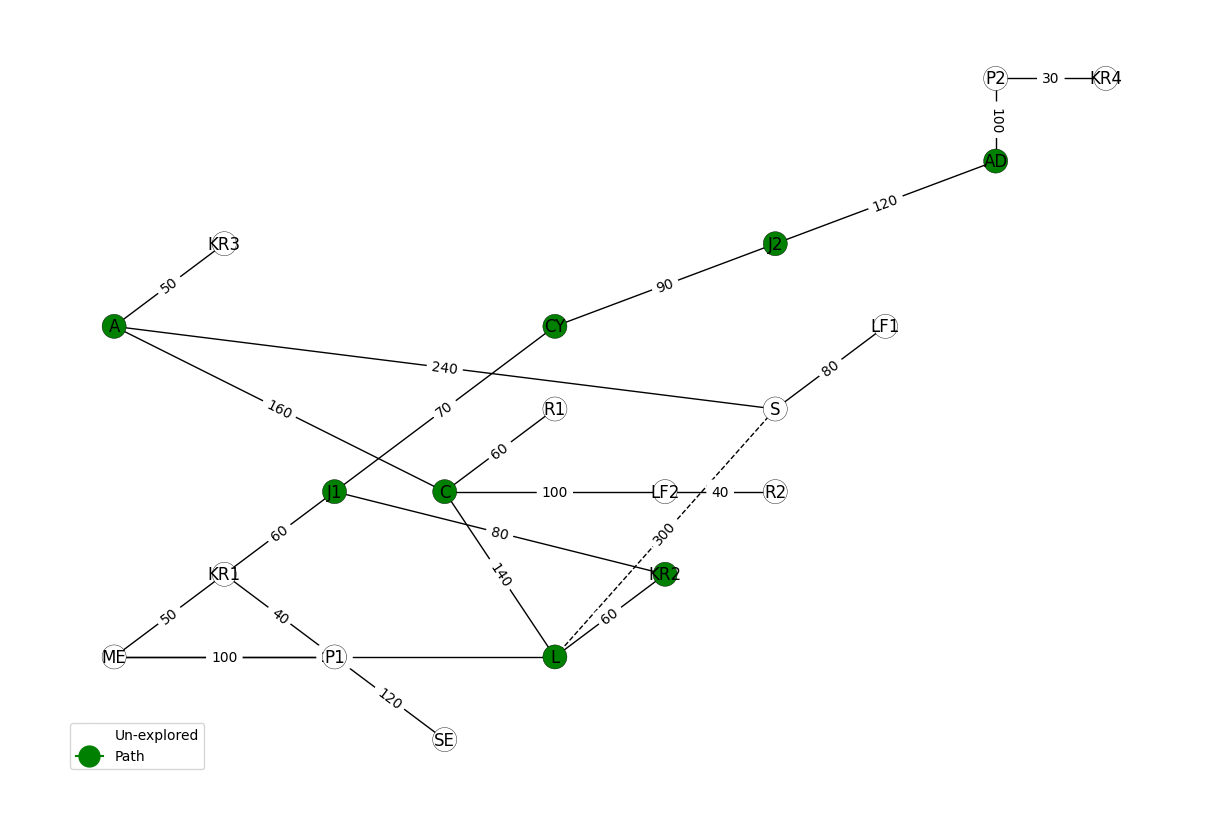

In [12]:


# Import necessary libraries
import math  # For mathematical operations (e.g., infinity)
import numpy as np  # For numerical computations (e.g., Euclidean distance)
import networkx as nx  # For graph data structures and algorithms
import matplotlib.pyplot as plt  # For plotting the graph
from matplotlib import lines  # For creating custom legend elements
import heapq  # For using a priority queue in A* search

# Graph class (from Task 1) - Represents a graph data structure
class Graph:
    def __init__(self, graph_dict=None, directed=True):
        """
        Initializes a new Graph object.

        Args:
            graph_dict (dict, optional): A dictionary representing the graph structure. Defaults to None.
            directed (bool, optional): True if the graph is directed, False if undirected. Defaults to True.
        """
        self.graph_dict = graph_dict or {}  # Store the graph as a dictionary
        self.directed = directed  # Whether the graph is directed or undirected
        if not directed:  # If the graph is undirected
            self.make_undirected()  # Make it undirected by adding reverse edges

    def make_undirected(self):
        """Converts the graph to undirected by adding reverse edges."""
        for a in list(self.graph_dict.keys()):  # Iterate through each node (a)
            for (b, dist) in self.graph_dict[a].items():  # Iterate through neighbors (b) and distances (dist)
                self.connect1(b, a, dist)  # Add a reverse edge from b to a

    def connect(self, A, B, distance=1):
        """Adds an edge between nodes A and B with the given distance."""
        self.connect1(A, B, distance)  # Add an edge from A to B
        if not self.directed:  # If undirected
            self.connect1(B, A, distance)  # Add an edge from B to A

    def connect1(self, A, B, distance):
        """Adds a directed edge from node A to node B with the given distance."""
        self.graph_dict.setdefault(A, {})[B] = distance  # Add the edge to the graph dictionary

    def get(self, a, b=None):
        """Retrieves connections from a node."""
        links = self.graph_dict.setdefault(a, {})  # Get connections from node a
        if b is None:  # If b is not specified
            return links  # Return all connections
        else:  # If b is specified
            return links.get(b)  # Return the distance to b

    def nodes(self):
        """Returns a list of all nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])  # Get all nodes that are keys in the graph
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])  # Get all nodes that are values
        nodes = s1.union(s2)  # Combine the two sets
        return list(nodes)  # Return the list of nodes


# Function to create an undirected graph
def UndirectedGraph(graph_dict=None):
    """Creates and returns an undirected Graph object."""
    return Graph(graph_dict=graph_dict, directed=False)  # Create an undirected Graph object


# Problem class (from Task 1) - Represents a generic search problem
class Problem(object):
    def __init__(self, initial, goal=None):
        """
        Initializes a new Problem instance.

        Args:
            initial: The initial state of the problem.
            goal: The desired goal state (can be a single state or a list of states).
        """
        self.initial = initial  # Store the initial state
        self.goal = goal  # Store the goal state

    def actions(self, state):
        """Returns the actions that can be executed in the given state."""
        raise NotImplementedError  # This method must be implemented by subclasses

    def result(self, state, action):
        """Returns the state that results from executing the given action in the given state."""
        raise NotImplementedError  # This method must be implemented by subclasses

    def goal_test(self, state):
        """Checks if the given state is a goal state."""
        if isinstance(self.goal, list):  # If the goal is a list of states
            return any(x == state for x in self.goal)  # Check if the state is in the goal list
        else:  # If the goal is a single state
            return state == self.goal  # Check if the state equals the goal

    def path_cost(self, c, state1, action, state2):
        """Returns the cost of a path that arrives at state2 from state1 via action."""
        return c + 1  # In this basic implementation, the cost is simply incremented by 1


# Node class (from Task 1) - Represents a node in the search tree
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        """
        Initializes a new Node object.

        Args:
            state: The state represented by this node.
            parent (Node, optional): The parent node. Defaults to None.
            action: The action that led to this state. Defaults to None.
            path_cost (int, optional): The cost to reach this state. Defaults to 0.
        """
        self.state = state  # Store the state
        self.parent = parent  # Store the parent node
        self.action = action  # Store the action
        self.path_cost = path_cost  # Store the path cost
        self.depth = 0  # Initialize depth to 0
        if parent:  # If there's a parent node
            self.depth = parent.depth + 1  # Increment depth

    def __repr__(self):
        """Returns a string representation of the Node."""
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        """Compares two nodes based on their states."""
        return self.state < node.state

    def expand(self, problem):
        """Generates child nodes by applying possible actions to the current state."""
        return [self.child_node(problem, action)  # Create child nodes for each action
                for action in problem.actions(self.state)]  # Get possible actions

    def child_node(self, problem, action):
        """Creates a new child node by applying an action to the current state."""
        next_state = problem.result(self.state, action)  # Get the next state
        next_node = Node(next_state, self, action,  # Create a new Node object
                         problem.path_cost(self.path_cost, self.state, action, next_state))  # Calculate path cost
        return next_node  # Return the new child node

    def solution(self):
        """Returns the sequence of actions that led to this node."""
        return [node.action for node in self.path()[1:]]  # Get actions from the path

    def path(self):
        """Reconstructs the path from the initial state to this node."""
        node, path_back = self, []  # Start with current node and empty path
        while node:  # While there's a node to trace back
            path_back.append(node)  # Add the current node to the path
            node = node.parent  # Move to the parent node
        return list(reversed(path_back))  # Reverse the path to get correct order

    def __eq__(self, other):
        """Checks if two nodes are equal (based on their states)."""
        return isinstance(other, Node) and self.state == other.state  # Compare states

    def __hash__(self):
        """Returns a hash value for the node, based on its state."""
        return hash(self.state)  # Enables using nodes in sets/dictionaries


# WheelchairProblem class (from Task 1) - Represents the wheelchair navigation problem
class WheelchairProblem(Problem):
    def __init__(self, initial, goal, graph):
        """
        Initializes a new WheelchairProblem instance.

        Args:
            initial: The initial state (starting location).
            goal: The goal state (destination location).
            graph: The graph representing the environment.
        """
        super().__init__(initial, goal)  # Initialize the base Problem class
        self.graph = graph  # Store the graph
        self.infinity = math.inf  # Define infinity for path cost calculations

    def actions(self, A):
        """Return neighboring locations accessible from the current state."""
        return list(self.graph.get(A).keys())  # Get the neighbors of the current state

    def result(self, state, action):
        """Move to the neighboring location specified by the action."""
        return action  # The result of an action is simply moving to the next state

    def path_cost(self, cost_so_far, A, action, B):
        """Calculate path cost, considering accessibility features."""
        return cost_so_far + (self.graph.get(A, B) or self.infinity)  # Add the edge cost to the current cost

    def h(self, node):
        """Heuristic: Euclidean distance to goal for A* search."""
        locs = self.graph.locations  # Get the locations dictionary
        if locs:  # If locations are defined
            if isinstance(node, str):  # If the node is a string (representing a state)
                return int(self.distance(locs[node], locs[self.goal]))  # Calculate distance to goal
            return int(self.distance(locs[node.state], locs[self.goal]))  # Calculate distance to goal
        return self.infinity  # If locations are not defined, return infinity

    def distance(self, a, b):
        """Calculate Euclidean distance between two coordinates."""
        xA, yA = a  # Get coordinates of point a
        xB, yB = b  # Get coordinates of point b
        return np.hypot((xA - xB), (yA - yB))  # Calculate Euclidean distance


# Environment from Task 1 - Defines the map for the wheelchair navigation problem
wheelchair_map = UndirectedGraph(dict(
    ME=dict(P1=100, KR1=50, L=200),  # Main Entrance and its connections
    P1=dict(ME=100, KR1=40, SE=120),  # Pathway 1 and its connections
    KR1=dict(ME=50, P1=40, J1=60),  # Kerb Ramp 1 and its connections
    L=dict(ME=200, KR2=60, C=140, S=300),  # Library (steep slope to S)
    C=dict(L=140, A=160, R1=60, LF2=100),  # Cafe
    S=dict(L=300, A=240, LF1=80),  # Study Area
    A=dict(S=240, KR3=50, C=160),  # Admin Building
    KR2=dict(L=60, J1=80),  # Kerb Ramp 2
    J1=dict(KR1=60, KR2=80, CY=70),  # Junction 1
    CY=dict(J1=70, J2=90),  # Courtyard
    J2=dict(CY=90, AD=120),  # Junction 2
    AD=dict(J2=120, P2=100),  # Academic Department
    P2=dict(AD=100, KR4=30),  # Pathway 2
    KR3=dict(A=50),  # Kerb Ramp 3
    KR4=dict(P2=30),  # Kerb Ramp 4
    LF1=dict(S=80),  # Lift 1
    LF2=dict(C=100, R2=40),  # Lift 2
    R1=dict(C=60),  # Restroom 1 (Goal)
    R2=dict(LF2=40),  # Restroom 2
    SE=dict(P1=120)  # Side Entrance
))


wheelchair_map.locations = dict(
    ME=(0, 0), P1=(100, 0), KR1=(50, 50), L=(200, 0), C=(150, 100),  # Locations of nodes
    S=(300, 150), A=(0, 200), R1=(200, 150), LF1=(350, 200), AD=(400, 300),
    J1=(100, 100), J2=(300, 250), CY=(200, 200), KR2=(250, 50), KR3=(50, 250),
    KR4=(450, 350), LF2=(250, 100), R2=(300, 100), SE=(150, -50), P2=(400, 350)
)

# Visualization data - Stores information for visualizing the map
node_colors = {node: 'white' for node in wheelchair_map.locations.keys()}  # Initialize all nodes to white
node_positions = wheelchair_map.locations  # Get node positions from the map
node_label_pos = {k: [v[0], v[1] - 20] for k, v in wheelchair_map.locations.items()}  # Calculate label positions
edge_weights = {(k, k2): v2 for k, v in wheelchair_map.graph_dict.items() for k2, v2 in v.items()}  # Get edge weights

wheelchair_graph_data = {
    'graph_dict': wheelchair_map.graph_dict,  # The graph structure
    'node_colors': node_colors,  # Node colors
    'node_positions': node_positions,  # Node positions
    'node_label_positions': node_label_pos,  # Node label positions
    'edge_weights': edge_weights  # Edge weights
}

# A* algorithm (from Task 2) - Finds the shortest path using A* search
def a_star_search(problem):
    """
    Performs A* search to find a path from the initial state to the goal state.

    Args:
        problem (Problem): The search problem instance.

    Returns:
        Node: The goal node if a path is found, otherwise None.
    """
    node = Node(problem.initial)  # Create the starting node
    frontier = [(problem.h(node), node)]  # Initialize the frontier (priority queue)
    explored = set()  # Initialize the explored set
    g_scores = {problem.initial: 0}  # Initialize g-scores (cost from start to node)
    f_scores = {problem.initial: problem.h(node)}  # Initialize f-scores (estimated total cost)

    while frontier:  # While there are nodes in the frontier
        _, current = heapq.heappop(frontier)  # Get the node with the lowest f-score
        if problem.goal_test(current.state):  # Check if the current node is the goal
            return current  # If it is, return the node

        explored.add(current.state)  # Add the current node to the explored set

        for action in problem.actions(current.state):  # Iterate through possible actions
            child = current.child_node(problem, action)  # Create a child node
            tentative_g = g_scores[current.state] + problem.path_cost(0, current.state, action, child.state)  # Calculate tentative g-score

            if child.state in explored and tentative_g >= g_scores.get(child.state, float('inf')):  # If child is already explored with a better path
                continue  # Skip this child

            if child.state not in g_scores or tentative_g < g_scores[child.state]:  # If child is not explored or has a better path
                g_scores[child.state] = tentative_g  # Update g-score
                f_scores[child.state] = tentative_g + problem.h(child)  # Update f-score
                heapq.heappush(frontier, (f_scores[child.state], child))  # Add child to frontier

    return None  # If no path is found


# Visualization function (from Task 2) - Displays the path on the map
def show_path(graph_data, path, start_node=None, end_node=None, heuristic_name=""):
    """
    Visualizes the path on the wheelchair map.

    Args:
        graph_data (dict): Dictionary containing graph structure and visualization data.
        path (list): List of Node objects representing the path.
    """
    G = nx.Graph(graph_data['graph_dict'])  # Create a NetworkX graph
    node_colors = {node: 'white' for node in G.nodes()}  # Initialize node colors to white
    node_positions = graph_data['node_positions']  # Get node positions
    node_label_pos = graph_data['node_label_positions']  # Get node label positions
    edge_weights = graph_data['edge_weights']  # Get edge weights

    for node in path:  # Iterate through nodes in the path
        node_colors[node.state] = 'green'  # Set the color of path nodes to green

    plt.figure(figsize=(12, 8))  # Create a figure for the plot
    edge_styles = []  # Initialize edge styles
    for edge in G.edges():  # Iterate through edges
        if edge in [('L', 'S'), ('S', 'L')]:  # Check for steep slope edges
            edge_styles.append('dashed')  # Set steep slope edges to dashed
        else:
            edge_styles.append('solid')  # Set other edges to solid

    nx.draw(G, pos=node_positions,  # Draw the graph
            node_color=[node_colors[node] for node in G.nodes()],  # Set node colors
            linewidths=0.3, edgecolors='k', with_labels=True,  # Style edges and labels
            style=edge_styles)  # Apply edge styles
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=10)  # Draw edge labels

    # Create legend elements
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    plt.legend((white_circle, green_circle),  # Add a legend
               ('Un-explored', 'Path'),
               numpoints=1, prop={'size': 10}, loc=(0.05, 0.05))
    plt.show()  # Show the plot


# User input function - Gets start and end nodes from the user
def get_user_input(graph):
    """Gets start and end nodes from the user."""
    nodes = sorted(graph.nodes())  # Get a sorted list of nodes
    print("Available nodes:", nodes)  # Print the available nodes

    while True:  # Loop until valid input is received
        start = input("Enter the starting node: ").strip()  # Get start node input
        if start in nodes:  # Check if start node is valid
            break  # Exit loop if valid
        print(f"Invalid node '{start}'. Please choose from the available nodes.")  # Print error message

    while True:  # Loop until valid input is received
        end = input("Enter the ending node: ").strip()  # Get end node input
        if end in nodes:  # Check if end node is valid
            break  # Exit loop if valid
        print(f"Invalid node '{end}'. Please choose from the available nodes.")  # Print error message

    return start, end  # Return the start and end nodes


# Main function to run the navigation system
def run_navigation(graph, graph_data):
    """Runs the navigation system."""
    start, end = get_user_input(graph)  # Get start and end nodes from the user
    problem = WheelchairProblem(start, end, graph)  # Create a WheelchairProblem instance
    result = a_star_search(problem)  # Run A* search to find a path

    if result:  # If a path is found
        path = result.path()  # Get the path
        print(f"Path from {start} to {end}:", [node.state for node in path])  # Print the path
        print("Path Cost:", result.path_cost)  # Print the path cost
        show_path(graph_data, path)  # Visualize the path
    else:  # If no path is found
        print(f"No path found from {start} to {end}.")  # Print a message


# Run the navigation system
run_navigation(wheelchair_map, wheelchair_graph_data)  # Start the navigation system




In [13]:



# Add new nodes and paths to the existing wheelchair_map
wheelchair_map.connect('CY', 'SL', 80)  # Connect Courtyard (CY) to Student Lounge (SL) with distance 80
wheelchair_map.connect('SL', 'C', 50)   # Connect Student Lounge (SL) to Cafe (C) with distance 50
wheelchair_map.connect('S', 'G', 60)    # Connect Study Area (S) to Garden (G) with distance 60
wheelchair_map.connect('G', 'LF1', 40)   # Connect Garden (G) to Lift 1 (LF1) with distance 40
wheelchair_map.connect('SE', 'PL', 70)   # Connect Side Entrance (SE) to Parking Lot (PL) with distance 70
wheelchair_map.connect('PL', 'P1', 90)   # Connect Parking Lot (PL) to Pathway 1 (P1) with distance 90
wheelchair_map.connect('AD', 'MC', 50)   # Connect Academic Department (AD) to Main Computer Lab (MC) with distance 50
wheelchair_map.connect('MC', 'P2', 30)   # Connect Main Computer Lab (MC) to Pathway 2 (P2) with distance 30
wheelchair_map.connect('C', 'OS', 40)    # Connect Cafe (C) to Office Supply (OS) with distance 40
wheelchair_map.connect('OS', 'R1', 20)   # Connect Office Supply (OS) to Restroom 1 (R1) with distance 20
wheelchair_map.connect('ME', 'BR', 30)   # Connect Main Entrance (ME) to Bookstore (BR) with distance 30
wheelchair_map.connect('BR', 'KR1', 20)   # Connect Bookstore (BR) to Kerb Ramp 1 (KR1) with distance 20


# Update coordinates for new nodes
wheelchair_map.locations.update({
    'SL': (250, 250),  # Near Courtyard (CY)
    'G': (350, 150),   # Near Study Area (S)
    'PL': (200, -50),  # Near Side Entrance (SE)
    'MC': (450, 300),  # Near Academic Department (AD)
    'OS': (200, 100),  # Near Cafe (C)
    'BR': (0, 50)      # Near Main Entrance (ME)
})

# Update visualization data
node_colors.update({
    'SL': 'white', 'G': 'white', 'PL': 'white',  # Initialize new nodes to white color
    'MC': 'white', 'OS': 'white', 'BR': 'white'
})
node_positions.update({
    'SL': (250, 250), 'G': (350, 150), 'PL': (200, -50),  # Update node positions for visualization
    'MC': (450, 300), 'OS': (200, 100), 'BR': (0, 50)
})
node_label_pos.update({
    'SL': [250, 230], 'G': [350, 130], 'PL': [200, -70],  # Update node label positions for visualization
    'MC': [450, 280], 'OS': [200, 80], 'BR': [0, 30]
})
edge_weights.update({
    ('CY', 'SL'): 80, ('SL', 'C'): 50, ('S', 'G'): 60,  # Update edge weights for visualization
    ('G', 'LF1'): 40, ('SE', 'PL'): 70, ('PL', 'P1'): 90,
    ('AD', 'MC'): 50, ('MC', 'P2'): 30, ('C', 'OS'): 40,
    ('OS', 'R1'): 20, ('ME', 'BR'): 30, ('BR', 'KR1'): 20
})

# Verify total path segments
total_segments = sum(len(connections) for connections in wheelchair_map.graph_dict.values()) // 2  # Undirected, so divide by 2
print(f"Total path segments: {total_segments}")  # Should be 34 # Output: Total path segments: 34

Total path segments: 34


In [14]:


class WheelchairProblem(Problem):
    """
    Represents a wheelchair navigation problem on a graph,
    inheriting from the base 'Problem' class.

    This class incorporates environmental constraints like blocked paths,
    rough terrain, and event closures to calculate path costs
    and guide the search for accessible routes.
    """
    def __init__(self, initial, goal, graph):
        """
        Initializes a new WheelchairProblem instance.

        Args:
            initial (str): The starting node (location) for the problem.
            goal (str): The desired goal node (location).
            graph (Graph): The graph representing the environment.
        """
        super().__init__(initial, goal)  # Initialize the base 'Problem' class
        self.graph = graph  # Store the graph representing the environment
        self.infinity = math.inf  # Define infinity for representing unreachable paths
        # Define environmental constraints
        self.blocked_paths = {('P1', 'PL'), ('PL', 'P1')}  # Construction barrier between P1 and PL
        self.rough_paths = {('S', 'G'), ('G', 'S')}  # Gravel paths between Study Area (S) and Garden (G)
        self.event_paths = {('CY', 'J2'), ('J2', 'CY')}  # Event closure between Courtyard (CY) and Junction 2 (J2)

    def actions(self, A):
        """
        Returns the possible actions (movements) from a given node.

        Args:
            A (str): The current node.

        Returns:
            list: A list of neighboring nodes accessible from node A.
        """
        return list(self.graph.get(A).keys())  # Get neighboring nodes from the graph

    def result(self, state, action):
        """
        Returns the resulting state after taking an action.

        Args:
            state (str): The current state (node).
            action (str): The action (movement to a neighboring node).

        Returns:
            str: The resulting state (node) after taking the action.
        """
        return action  # In this case, the action is simply moving to the neighboring node

    def path_cost(self, cost_so_far, A, action, B, is_event_time=False):
        """
        Calculates the cost of moving from node A to node B,
        considering environmental constraints.

        Args:
            cost_so_far (int): The accumulated cost up to node A.
            A (str): The current node.
            action (str): The action (movement to node B).
            B (str): The next node.
            is_event_time (bool, optional): True if it's during an event,
                                           affecting path availability. Defaults to False.

        Returns:
            int: The total cost of the path up to node B.
        """
        # Check for blocked paths (construction)
        if (A, B) in self.blocked_paths or (B, A) in self.blocked_paths:
            return self.infinity  # Return infinity if the path is blocked

        # Check for event closure
        if is_event_time and ((A, B) in self.event_paths or (B, A) in self.event_paths):
            return self.infinity  # Return infinity if the path is closed due to an event

        # Base cost
        base_cost = self.graph.get(A, B) or self.infinity  # Get the base cost from the graph

        # Adjust cost for rough terrain (gravel paths)
        if (A, B) in self.rough_paths or (B, A) in self.rough_paths:
            return cost_so_far + base_cost * 1.3  # 30% penalty for rough terrain

        # Adjust cost for steep slopes (already in environment)
        if (A, B) in [('L', 'S'), ('S', 'L')]:
            return cost_so_far + base_cost  # Already adjusted to 300m

        return cost_so_far + base_cost  # Return the total cost

    def h(self, node):
        """
        Heuristic function: Estimates the distance from a node to the goal.

        Args:
            node (Node or str): The node to estimate the distance from.

        Returns:
            int: The estimated distance to the goal.
        """
        locs = self.graph.locations  # Get node locations from the graph
        if locs:
            if isinstance(node, str):  # If node is a string (node name)
                return int(self.distance(locs[node], locs[self.goal]))  # Calculate distance to goal
            return int(self.distance(locs[node.state], locs[self.goal]))  # Calculate distance to goal
        return self.infinity  # Return infinity if locations are not available

    def h_accessibility(self, node, is_event_time=False):
      locs = self.graph.locations
      if not locs:
        return self.infinity
      if isinstance(node, str):
          current_pos = locs[node]
          current_state = node
      else:
          current_pos = locs[node.state]
          current_state = node.state
      goal_pos = locs[self.goal]
      goal_state = self.goal

      base_dist = self.distance(current_pos, goal_pos)

      # Steep slope penalty: Apply if either node is S or L, as the path might go through the other
      steep_slope_penalty = 0
      if ('S' in [current_state, goal_state] or 'L' in [current_state, goal_state]):
          steep_slope_penalty = 50  # Likely to encounter the steep slope

      # Rough terrain penalty: Apply if either node is S or G
      rough_terrain_penalty = 0
      if ('S' in [current_state, goal_state] or 'G' in [current_state, goal_state]):
          rough_terrain_penalty = 20  # Likely to encounter rough terrain

      # Event closure penalty: Apply if either node is CY or J2
      detour_penalty = 0
      if is_event_time and ('CY' in [current_state, goal_state] or 'J2' in [current_state, goal_state]):
          detour_penalty = 50  # Likely to encounter event closure

      return int(base_dist + steep_slope_penalty + rough_terrain_penalty + detour_penalty)



    def distance(self, a, b):
        """
        Calculates the Euclidean distance between two points.

        Args:
            a (tuple): Coordinates of the first point (x, y).
            b (tuple): Coordinates of the second point (x, y).

        Returns:
            float: The Euclidean distance between the two points.
        """
        xA, yA = a  # Extract x and y coordinates of point a
        xB, yB = b  # Extract x and y coordinates of point b
        return np.hypot((xA - xB), (yA - yB))  # Calculate and return the distance

In [15]:

def a_star_search(problem, use_accessibility_heuristic=True, is_event_time=True):
    """
    Performs A* search to find a path from the initial state to the goal state.

    Args:
        problem (Problem): The search problem instance.
        use_accessibility_heuristic (bool, optional): Whether to use the accessibility-aware heuristic. Defaults to False.
        is_event_time (bool, optional): Whether it's during an event (affecting path availability). Defaults to False.

    Returns:
        Node: The goal node if a path is found, otherwise None.
    """
    # Create the starting node with the initial state
    node = Node(problem.initial)

    # Initialize the frontier (priority queue) with the starting node and its heuristic value
    # Use the accessibility heuristic if specified, otherwise use the default heuristic
    frontier = [(problem.h_accessibility(node, is_event_time) if use_accessibility_heuristic else problem.h(node), node)]

    # Keep track of explored states to avoid cycles
    explored = set()

    # Store the cost to reach each node from the start (g-score)
    g_scores = {problem.initial: 0}

    # Store the estimated total cost (f-score = g-score + heuristic)
    f_scores = {problem.initial: problem.h_accessibility(node, is_event_time) if use_accessibility_heuristic else problem.h(node)}

    # Main search loop: continue as long as there are nodes in the frontier
    while frontier:
        # Get the node with the lowest f-score from the frontier
        _, current = heapq.heappop(frontier)

        # Check if the current node's state is the goal state
        if problem.goal_test(current.state):
            return current  # If it is the goal state, return the node (path found)

        # Mark the current node's state as explored
        explored.add(current.state)

        # Explore neighboring nodes (possible actions from the current state)
        for action in problem.actions(current.state):
            # Create a child node by applying the action
            child = current.child_node(problem, action)

            # Calculate the tentative g-score for the child
            tentative_g = g_scores[current.state] + problem.path_cost(0, current.state, action, child.state, is_event_time)

            # Check if the child node has already been explored with a lower or equal cost
            if child.state in explored and tentative_g >= g_scores.get(child.state, float('inf')):
                continue  # Skip this child node if it's already explored with a better path

            # Update g-score and f-score if a better path to the child is found
            if child.state not in g_scores or tentative_g < g_scores[child.state]:
                g_scores[child.state] = tentative_g  # Update g-score

                # Calculate heuristic value (accessibility-aware or default)
                h_value = problem.h_accessibility(child, is_event_time) if use_accessibility_heuristic else problem.h(child)

                f_scores[child.state] = tentative_g + h_value  # Update f-score

                # Add the child to the frontier with its f-score
                heapq.heappush(frontier, (f_scores[child.state], child))

    # If the frontier is empty and the goal hasn't been found, there's no path
    return None


In [18]:


def show_path(graph_data, path, start_node=None, end_node=None, heuristic_name=""):
    """
    Visualizes the path on the wheelchair map.

    Args:
        graph_data (dict): Dictionary containing graph structure and visualization data.
        path (list): List of Node objects representing the path.
        start_node (str, optional): Starting node of the path. Defaults to None.
        end_node (str, optional): Ending node of the path. Defaults to None.
        heuristic_name (str, optional): Name of the heuristic used. Defaults to "".
    """
    # Create a NetworkX graph object from the graph data
    G = nx.Graph(graph_data['graph_dict'])

    # Initialize node colors and sizes
    node_colors = {}
    node_sizes = []

    # Set default node colors and sizes based on node type
    for node in G.nodes():  # Iterate through each node in the graph
        if node in ['ME', 'SE']:  # Entrances
            node_colors[node] = 'lightblue'
            node_sizes.append(500)
        elif node in ['A', 'AD', 'C', 'L', 'S', 'G', 'MC', 'SL']:  # Buildings
            node_colors[node] = 'lightgreen'
            node_sizes.append(500)
        elif node.startswith('KR'):  # Kerb ramps
            node_colors[node] = 'yellow'
            node_sizes.append(400)
        elif node.startswith('LF'):  # Lifts
            node_colors[node] = 'orange'
            node_sizes.append(400)
        elif node.startswith('R'):  # Restrooms
            node_colors[node] = 'pink'
            node_sizes.append(400)
        elif node in ['PL', 'BR']:  # Parking or Bike Rack
            node_colors[node] = 'mediumpurple'
            node_sizes.append(400)
        elif node == 'OS':  # Outdoor Seating
            node_colors[node] = 'lightcoral'
            node_sizes.append(400)
        else:  # Other nodes (junctions, pathways)
            node_colors[node] = 'lightgray'
            node_sizes.append(300)

    # Highlight nodes in the path with green color
    for node in path:  # Iterate through nodes in the solution path
        node_colors[node.state] = 'limegreen'  # Set color to green

    # Get node positions, label positions, and edge weights from graph data
    node_positions = graph_data['node_positions']
    node_label_pos = graph_data['node_label_positions']
    edge_weights = graph_data['edge_weights']

    # Create the Matplotlib figure and set its size and background color
    plt.figure(figsize=(16, 12), facecolor='lightgray')
    # Set the title of the plot based on start and end nodes, and heuristic
    if start_node and end_node:
        plt.title(f"Path from {start_node} to {end_node} ({heuristic_name})", fontsize=16, pad=20)
    else:
        plt.title("Wheelchair Navigation Path", fontsize=16, pad=20)

    # Define edge styles, colors, and widths based on edge type
    edge_styles = []
    edge_colors = []
    edge_widths = []
    for edge in G.edges():  # Iterate through each edge in the graph
        if edge in [('P1', 'PL'), ('PL', 'P1')]:  # Blocked path
            edge_styles.append('dotted')
            edge_colors.append('gray')
            edge_widths.append(1.0)
        elif edge in [('S', 'G'), ('G', 'S')]:  # Rough terrain
            edge_styles.append('solid')
            edge_colors.append('brown')
            edge_widths.append(1.5)
        elif edge in [('CY', 'J2'), ('J2', 'CY')]:  # Event closure
            edge_styles.append('solid')
            edge_colors.append('purple')
            edge_widths.append(1.5)
        elif edge in [('L', 'S'), ('S', 'L')]:  # Steep slope
            edge_styles.append('dashed')
            edge_colors.append('red')
            edge_widths.append(1.5)
        else:  # Flat path (default)
            edge_styles.append('solid')
            edge_colors.append('blue')
            edge_widths.append(1.0)

    # Highlight path edges with limegreen color and increased width
    path_edges = [(path[i].state, path[i+1].state) for i in range(len(path)-1)]  # Get edges in the solution path
    for i, edge in enumerate(G.edges()):  # Iterate through all edges
        if edge in path_edges or (edge[1], edge[0]) in path_edges:  # Check if edge is in the path
            edge_colors[i] = 'limegreen'  # Set color to limegreen
            edge_widths[i] = 3.0  # Increase width

    # Draw the graph using NetworkX and Matplotlib with specified styles and colors
    nx.draw(G, pos=node_positions,  # Node positions
            node_color=[node_colors[node] for node in G.nodes()],  # Node colors
            node_size=node_sizes,  # Node sizes
            linewidths=0.5, edgecolors='black', with_labels=True,  # Node and edge styling
            font_size=12, font_weight='bold',  # Label styling
            edge_color=edge_colors, width=edge_widths, style=edge_styles)  # Edge styling

    # Add edge labels (weights)
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=10)

    # Add annotations for specific constraints (construction, terrain, event)
    plt.annotate("Construction\nBarrier", xy=(node_positions['P1'][0] + 50, node_positions['P1'][1] - 20),  # Annotation position
                 xytext=(node_positions['P1'][0] + 100, node_positions['P1'][1] - 50),  # Text position
                 arrowprops=dict(facecolor='gray', shrink=0.05), fontsize=10, color='gray')  # Arrow and text styling
    plt.annotate("Rough\nTerrain", xy=(node_positions['S'][0] + 20, node_positions['S'][1] + 20),  # Annotation position
                 xytext=(node_positions['S'][0] + 50, node_positions['S'][1] + 50),  # Text position
                 arrowprops=dict(facecolor='brown', shrink=0.05), fontsize=10, color='brown')  # Arrow and text styling
    plt.annotate("Event\nClosure", xy=(node_positions['CY'][0] + 20, node_positions['CY'][1] + 20),  # Annotation position
                 xytext=(node_positions['CY'][0] + 50, node_positions['CY'][1] + 50),  # Text position
                 arrowprops=dict(facecolor='purple', shrink=0.05), fontsize=10, color='purple')  # Arrow and text styling

    # Create legend elements for different node and edge types
    entrance = lines.Line2D([], [], color="lightblue", marker='o', markersize=10, label="Entrances (ME, SE)")
    building = lines.Line2D([], [], color="lightgreen", marker='o', markersize=10, label="Buildings (A, AD, C, L, S, G, MC, SL)")
    kerb_ramp = lines.Line2D([], [], color="yellow", marker='o', markersize=10, label="Kerb Ramps (KR1, KR2, etc.)")
    lift = lines.Line2D([], [], color="orange", marker='o', markersize=10, label="Lifts (LF1, LF2)")
    restroom = lines.Line2D([], [], color="pink", marker='o', markersize=10, label="Restrooms (R1, R2)")
    parking = lines.Line2D([], [], color="mediumpurple", marker='o', markersize=10, label="Parking/Bike Rack (PL, BR)")
    seating = lines.Line2D([], [], color="lightcoral", marker='o', markersize=10, label="Outdoor Seating (OS)")
    junction = lines.Line2D([], [], color="lightgray", marker='o', markersize=10, label="Junctions/Pathways")
    path_node = lines.Line2D([], [], color="limegreen", marker='o', markersize=10, label="Path")
    flat_path = lines.Line2D([], [], color="blue", linestyle='solid', linewidth=2, label="Flat Path")
    steep_slope = lines.Line2D([], [], color="red", linestyle='dashed', linewidth=2, label="Steep Slope")
    rough_terrain = lines.Line2D([], [], color="brown", linestyle='solid', linewidth=2, label="Rough Terrain")
    event_closure = lines.Line2D([], [], color="purple", linestyle='solid', linewidth=2, label="Event Closure")
    blocked_path = lines.Line2D([], [], color="gray", linestyle='dotted', linewidth=2, label="Blocked Path")
    path_edge = lines.Line2D([], [], color="limegreen", linestyle='solid', linewidth=3, label="Path Edge")

    # Add a legend to the plot
    plt.legend(handles=[entrance, building, kerb_ramp, lift, restroom, parking, seating, junction, path_node, flat_path, steep_slope, rough_terrain, event_closure, blocked_path, path_edge],
               loc=(0.9, 0.05), fontsize=10, frameon=True, facecolor='white', edgecolor='black')  # Legend styling and position

    # Display the plot
    plt.show()


In [19]:



def dijkstra_search(problem, is_event_time=False):
    """
    Dijkstra's Algorithm for finding the shortest path without a heuristic.

    Args:
        problem (Problem): The search problem instance.
        is_event_time (bool, optional): Flag to consider event-related constraints. Defaults to False.

    Returns:
        list or None: The shortest path as a list of Node objects if found, otherwise None.
    """
    # Initialize the starting node and frontier (priority queue)
    node = Node(problem.initial)  # Create a starting node with the initial state
    frontier = [(0, node)]  # Priority queue stores (cost, node) tuples, initialized with the starting node and cost 0

    # Initialize sets and dictionaries to track exploration and costs
    explored = set()  # Set to store explored nodes (states)
    g_scores = {problem.initial: 0}  # Dictionary to store the cost to reach each node from the start (g-score)
    came_from = {problem.initial: None}  # Dictionary to store the parent node of each node for path reconstruction

    # Main loop of Dijkstra's algorithm
    while frontier:  # While there are nodes in the frontier (unexplored nodes)
        g_score, current = heapq.heappop(frontier)  # Get the node with the lowest g-score from the frontier using a heap

        # Check if the current node is the goal
        if problem.goal_test(current.state):  # If the current node's state is the goal state
            # Reconstruct the path by backtracking from the goal to the start
            path = []  # Initialize an empty list to store the path
            while current:  # While we haven't reached the starting node (which has a parent of None)
                path.append(current)  # Add the current node to the path
                current = came_from[current.state]  # Move to the parent node
            return list(reversed(path))  # Return the reversed path (from start to goal)

        # Mark the current node as explored
        explored.add(current.state)  # Add the current node's state to the explored set

        # Explore neighbors of the current node
        for action in problem.actions(current.state):  # Iterate through possible actions from the current state
            child = current.child_node(problem, action)  # Create a child node by applying the action
            tentative_g = g_scores[current.state] + problem.path_cost(0, current.state, action, child.state, is_event_time)  # Calculate the tentative g-score for the child

            # Check if a better path to the child node has been found
            if child.state in explored and tentative_g >= g_scores.get(child.state, float('inf')):  # If child is already explored and tentative cost is not better
                continue  # Skip this child node

            # Update g-score and parent if a better path is found
            if child.state not in g_scores or tentative_g < g_scores[child.state]:  # If child is unexplored or tentative cost is better
                g_scores[child.state] = tentative_g  # Update the g-score for the child
                came_from[child.state] = current  # Update the parent of the child
                heapq.heappush(frontier, (tentative_g, child))  # Add the child to the frontier with its g-score

    # If no path is found, return None
    return None  # No path found


=== Test Case: ME to R1 (Event Time: False) ===
Euclidean Heuristic (A*) Path: ['ME', 'KR1', 'J1', 'CY', 'SL', 'C', 'R1']
Euclidean Heuristic (A*) Cost: 370
Euclidean Heuristic (A*) Time: 0.0004696846008300781 seconds
Euclidean Heuristic (A*) Nodes Explored: 26
Accessibility-Adjusted Heuristic (A*) Path: ['ME', 'KR1', 'J1', 'CY', 'SL', 'C', 'R1']
Accessibility-Adjusted Heuristic (A*) Cost: 370
Accessibility-Adjusted Heuristic (A*) Time: 0.0003428459167480469 seconds
Accessibility-Adjusted Heuristic (A*) Nodes Explored: 26
Dijkstra's Algorithm Path: ['ME', 'KR1', 'J1', 'CY', 'SL', 'C', 'R1']
Dijkstra's Algorithm Cost: 370
Dijkstra's Algorithm Time: 0.000301361083984375 seconds
Dijkstra's Algorithm Nodes Explored: 26


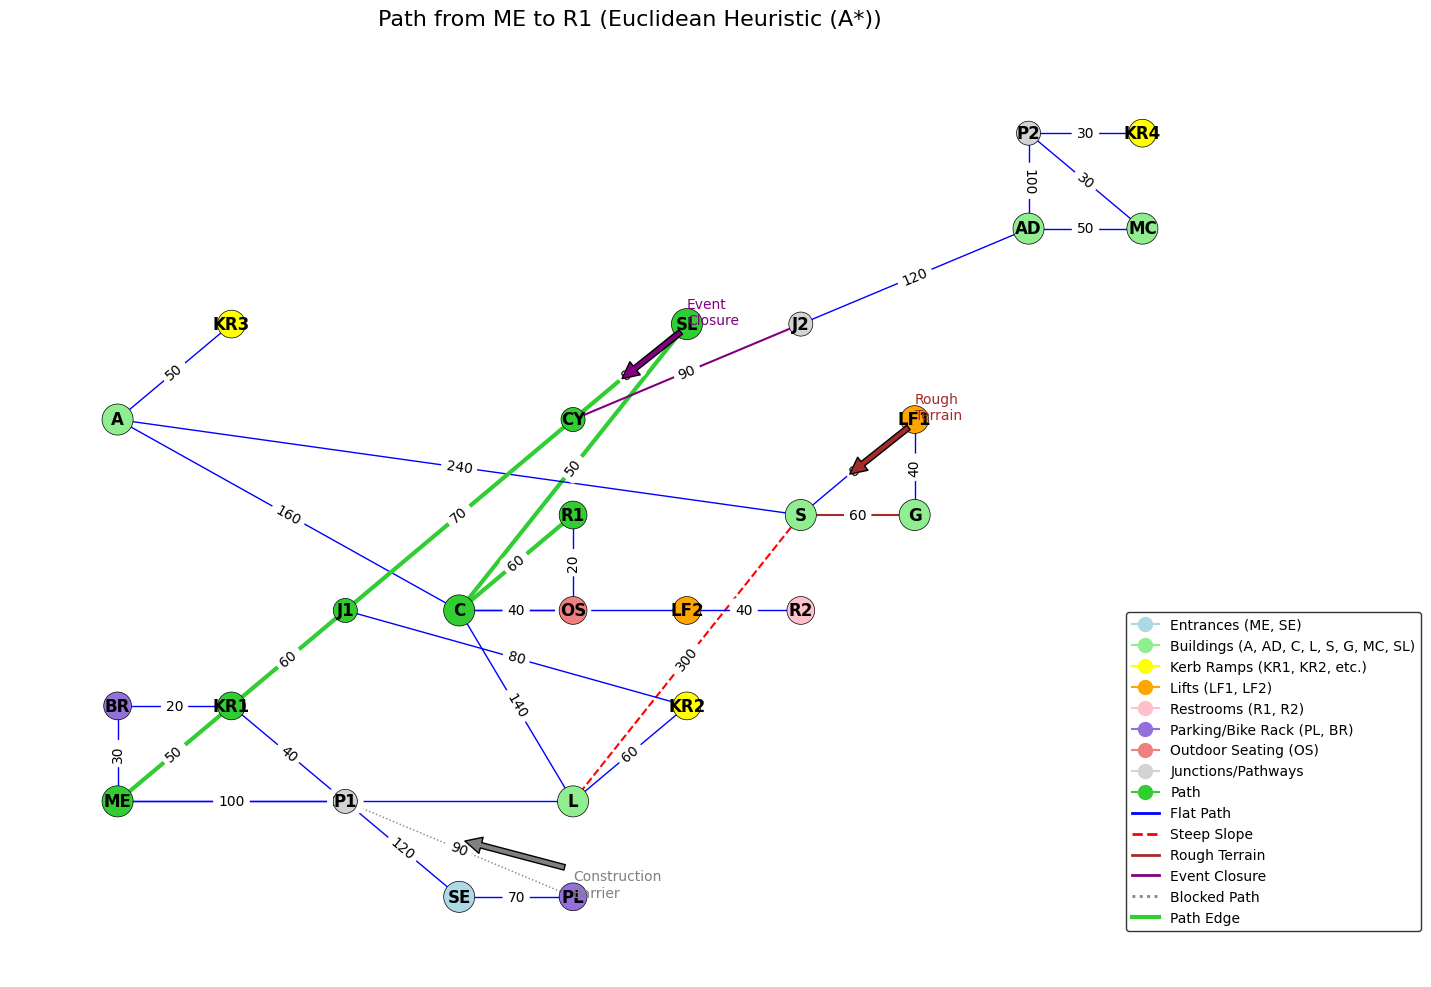

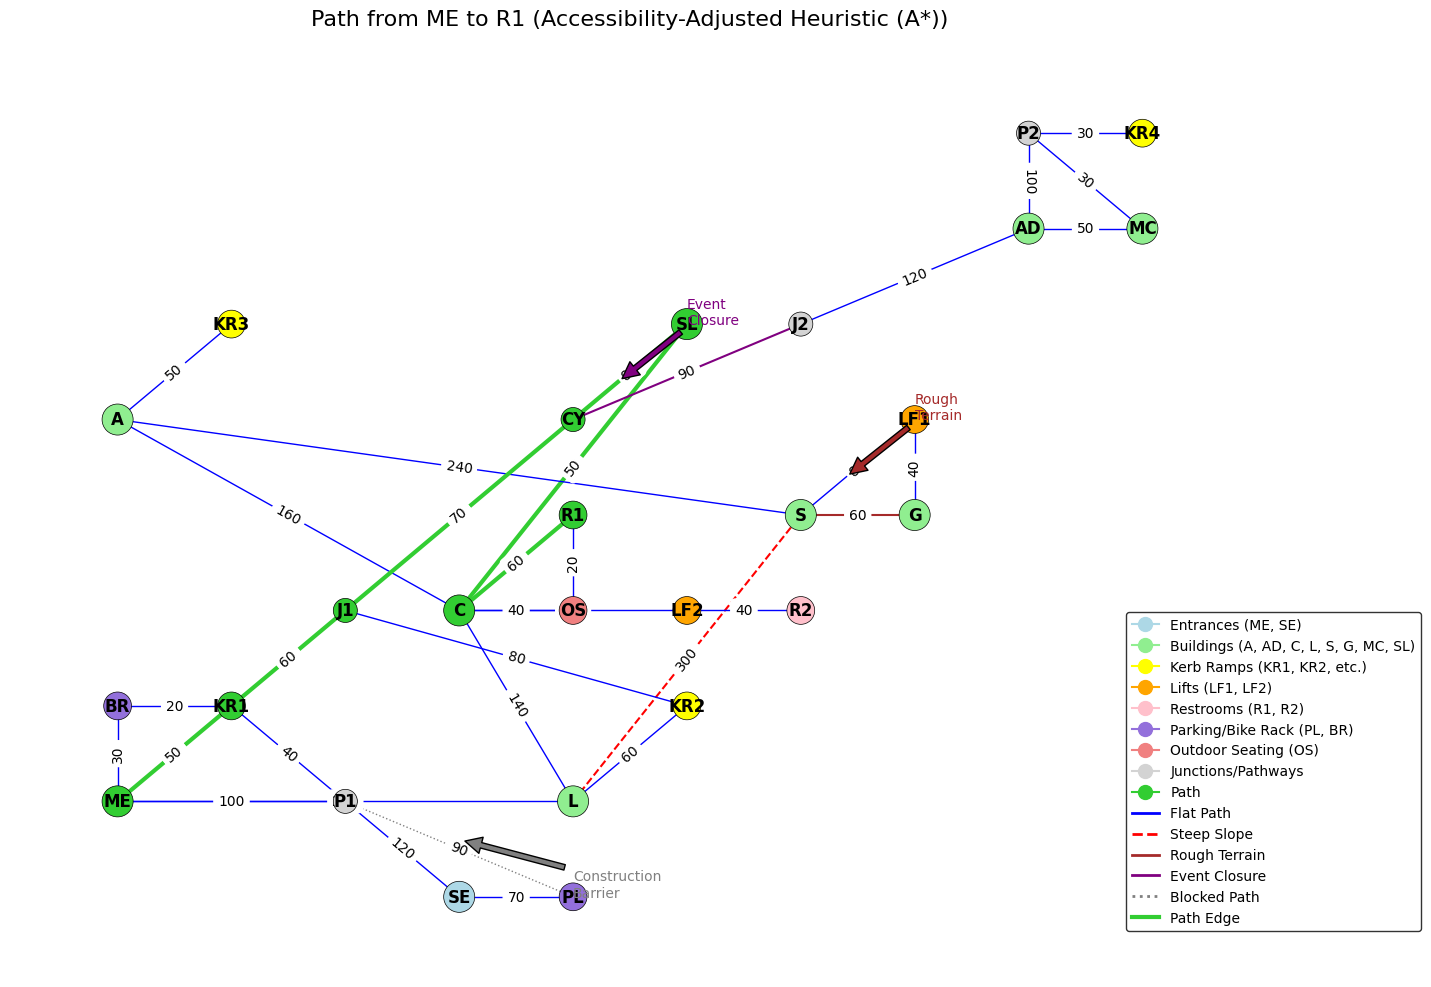

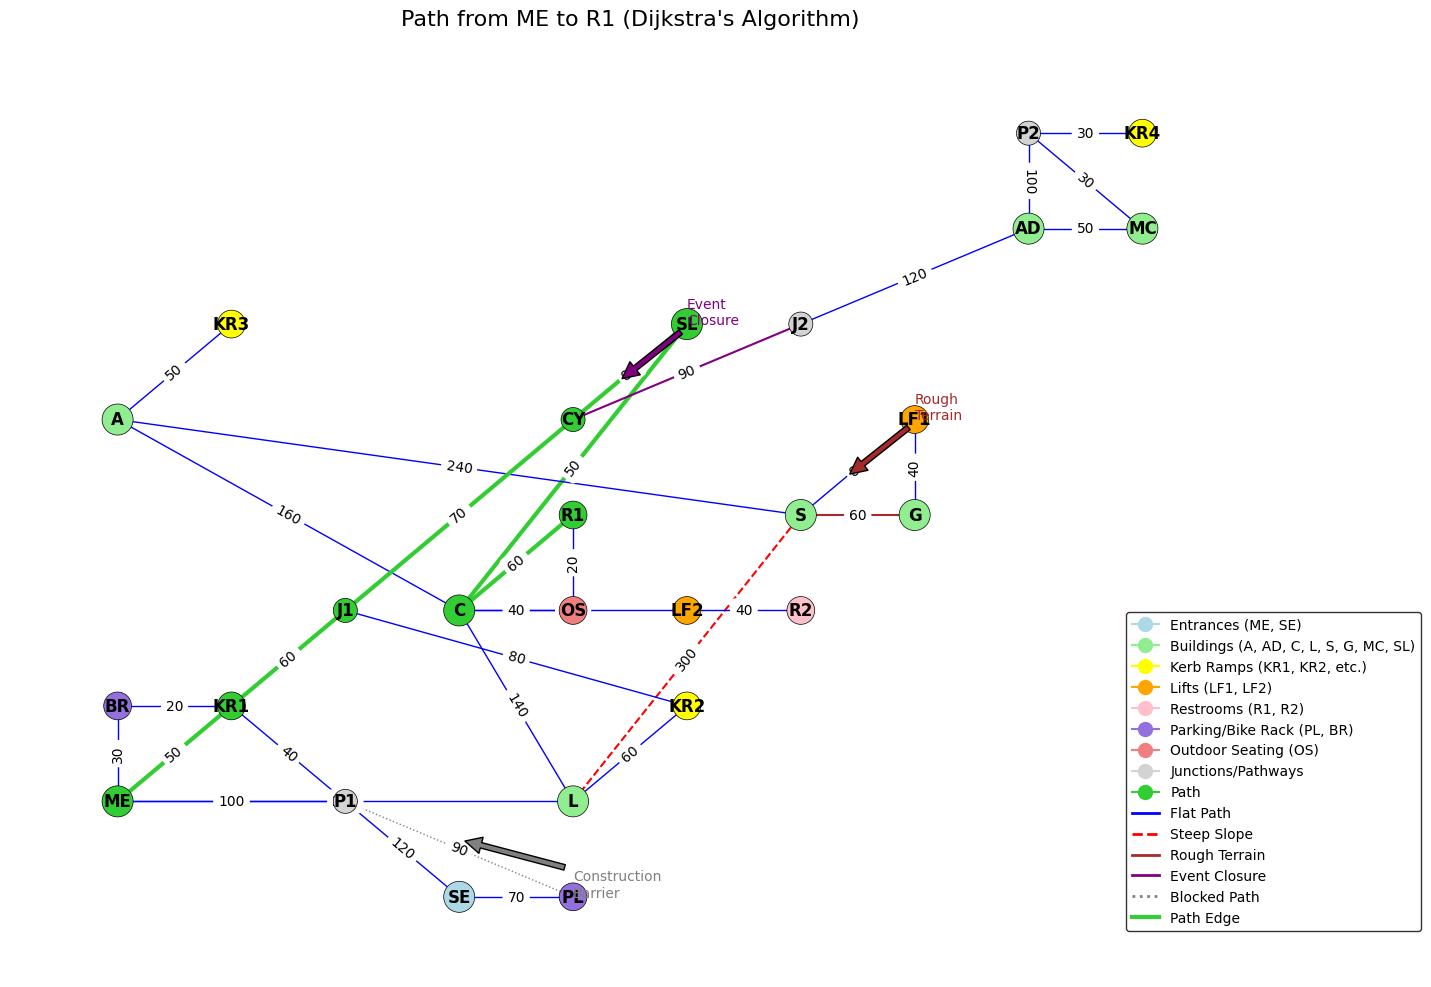


=== Test Case: A to LF1 (Event Time: False) ===
Euclidean Heuristic (A*) Path: ['A', 'S', 'LF1']
Euclidean Heuristic (A*) Cost: 320
Euclidean Heuristic (A*) Time: 0.000156402587890625 seconds
Euclidean Heuristic (A*) Nodes Explored: 26
Accessibility-Adjusted Heuristic (A*) Path: ['A', 'S', 'LF1']
Accessibility-Adjusted Heuristic (A*) Cost: 320
Accessibility-Adjusted Heuristic (A*) Time: 0.00011444091796875 seconds
Accessibility-Adjusted Heuristic (A*) Nodes Explored: 26
Dijkstra's Algorithm Path: ['A', 'S', 'LF1']
Dijkstra's Algorithm Cost: 320
Dijkstra's Algorithm Time: 0.00021266937255859375 seconds
Dijkstra's Algorithm Nodes Explored: 26


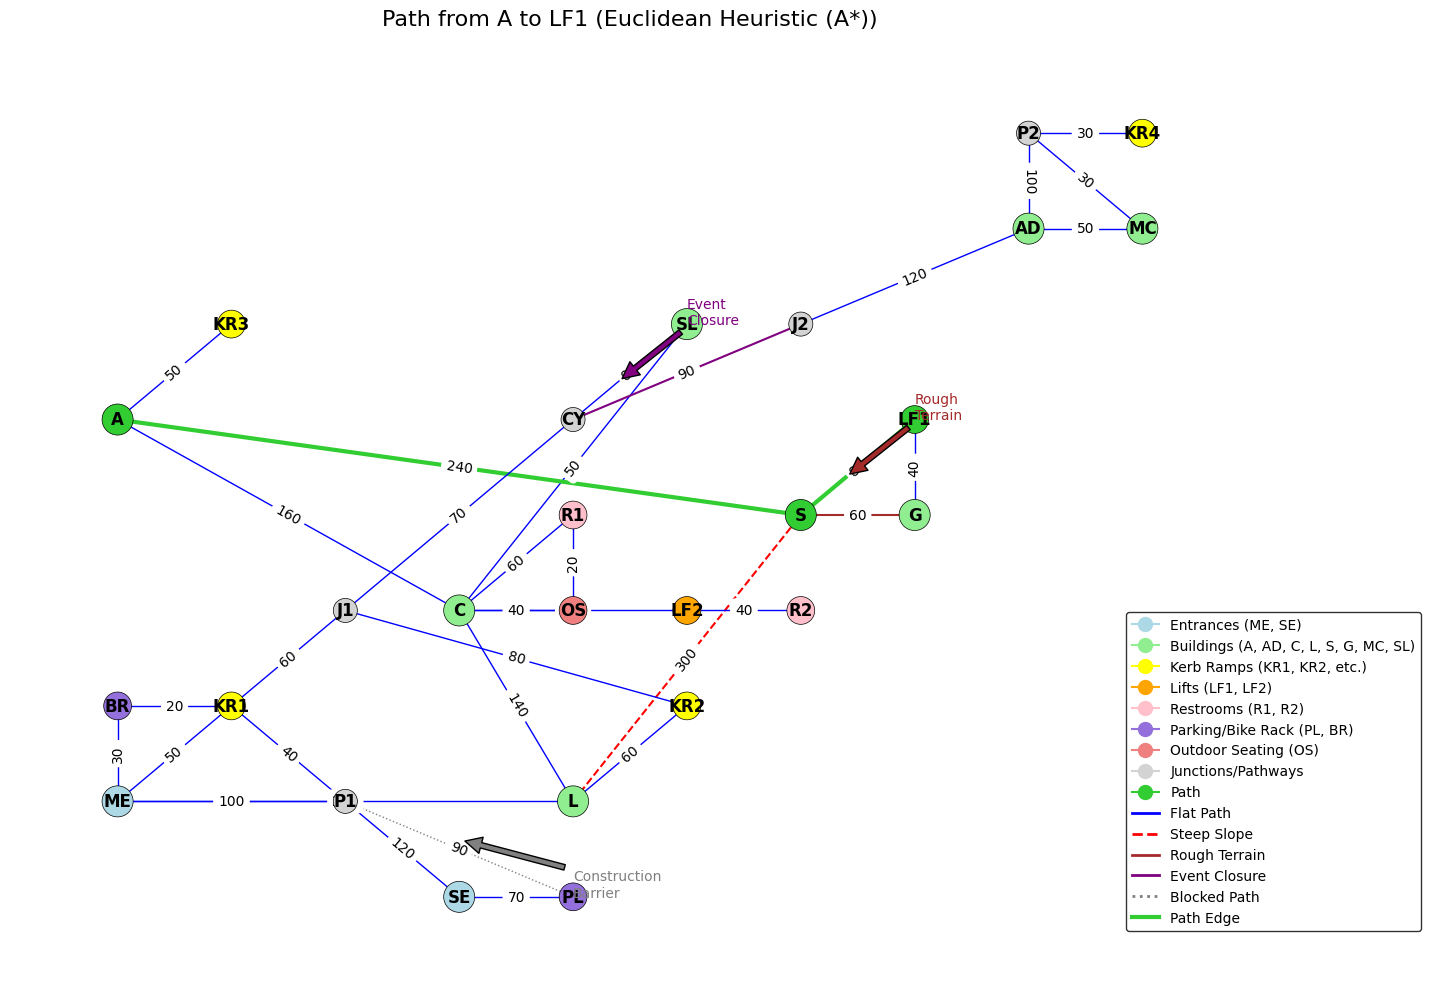

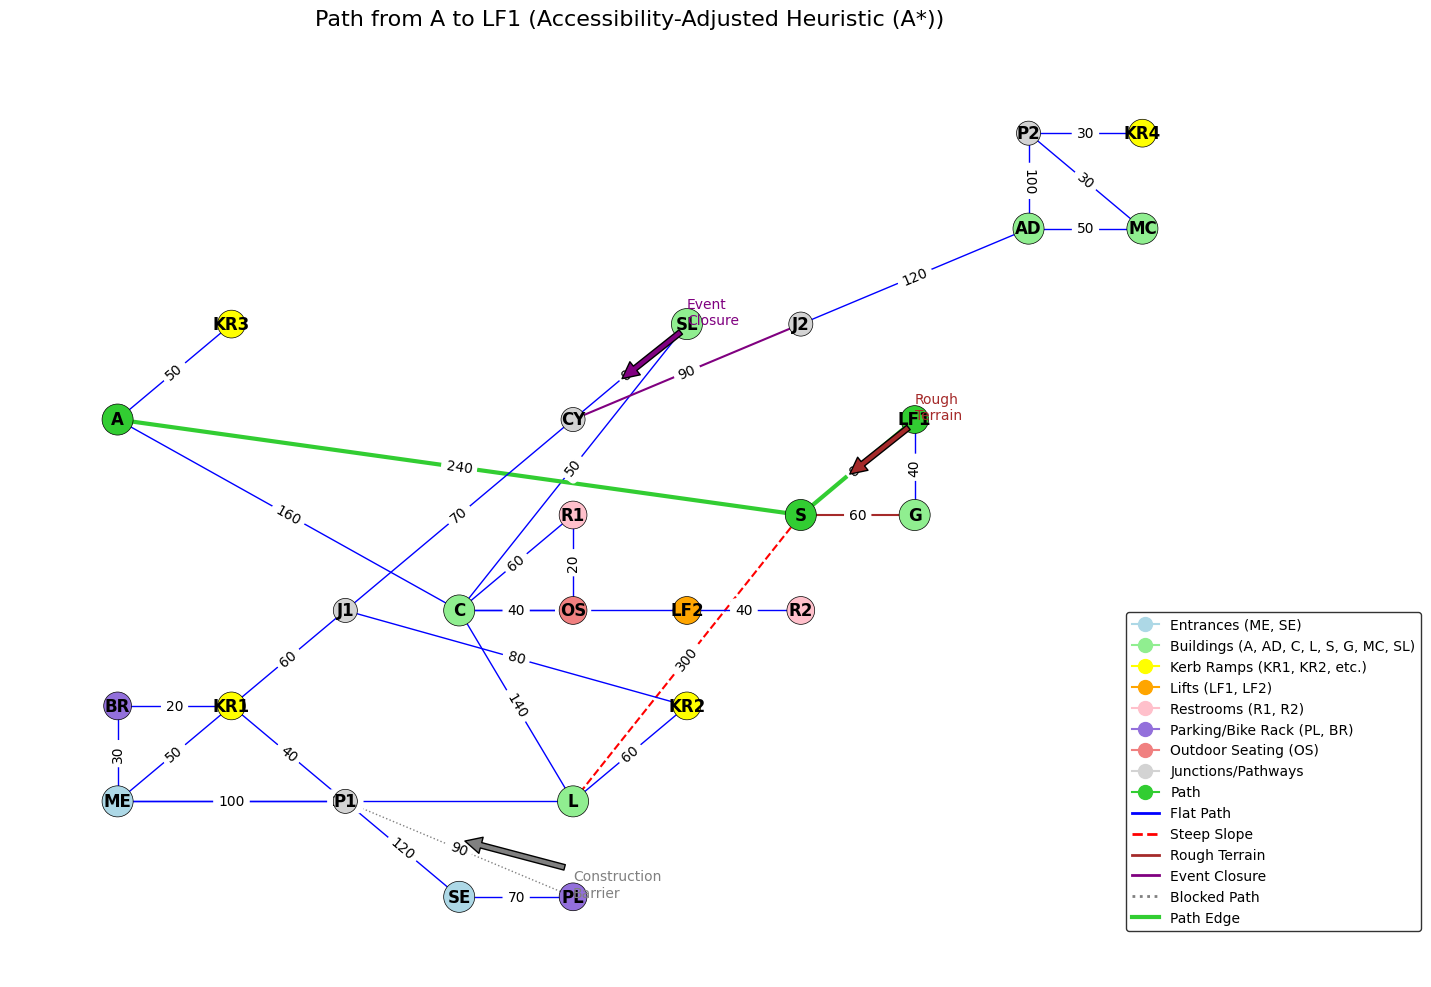

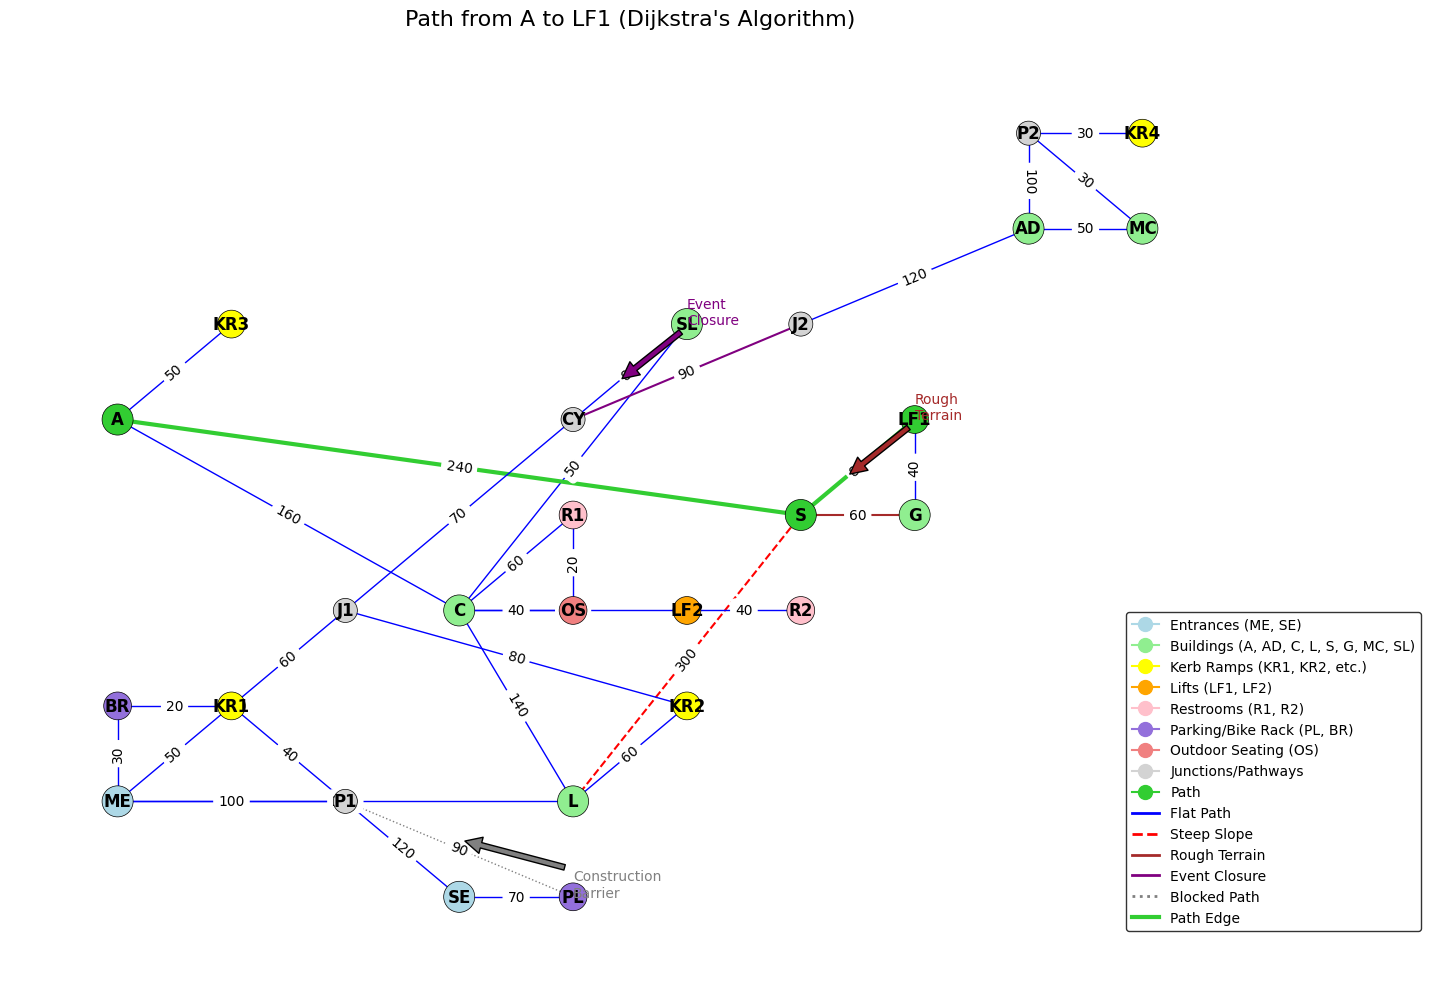


=== Test Case: SE to AD (Event Time: True) ===
Euclidean Heuristic (A*) Path: ['SE', 'P1', 'KR1', 'J1', 'CY', 'J2', 'AD']
Euclidean Heuristic (A*) Cost: 500
Euclidean Heuristic (A*) Time: 0.0003552436828613281 seconds
Euclidean Heuristic (A*) Nodes Explored: 26
Accessibility-Adjusted Heuristic (A*) Path: ['SE', 'P1', 'KR1', 'J1', 'CY', 'J2', 'AD']
Accessibility-Adjusted Heuristic (A*) Cost: 500
Accessibility-Adjusted Heuristic (A*) Time: 0.00028395652770996094 seconds
Accessibility-Adjusted Heuristic (A*) Nodes Explored: 26
Dijkstra's Algorithm Path: ['SE', 'P1', 'KR1', 'J1', 'CY', 'J2', 'AD']
Dijkstra's Algorithm Cost: inf
Dijkstra's Algorithm Time: 0.0003485679626464844 seconds
Dijkstra's Algorithm Nodes Explored: 26


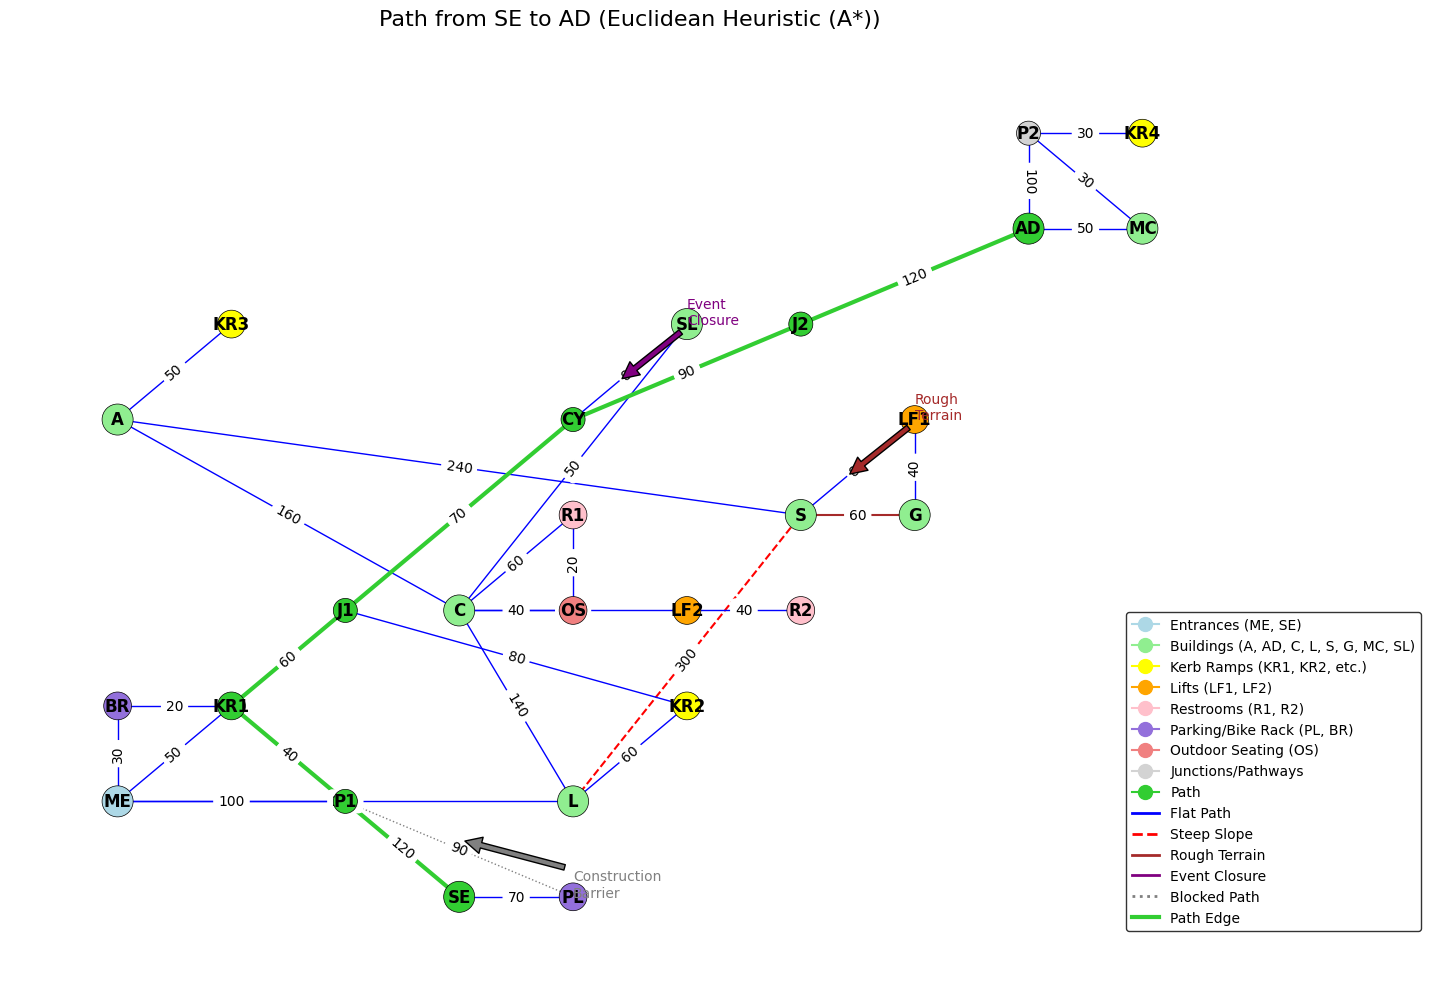

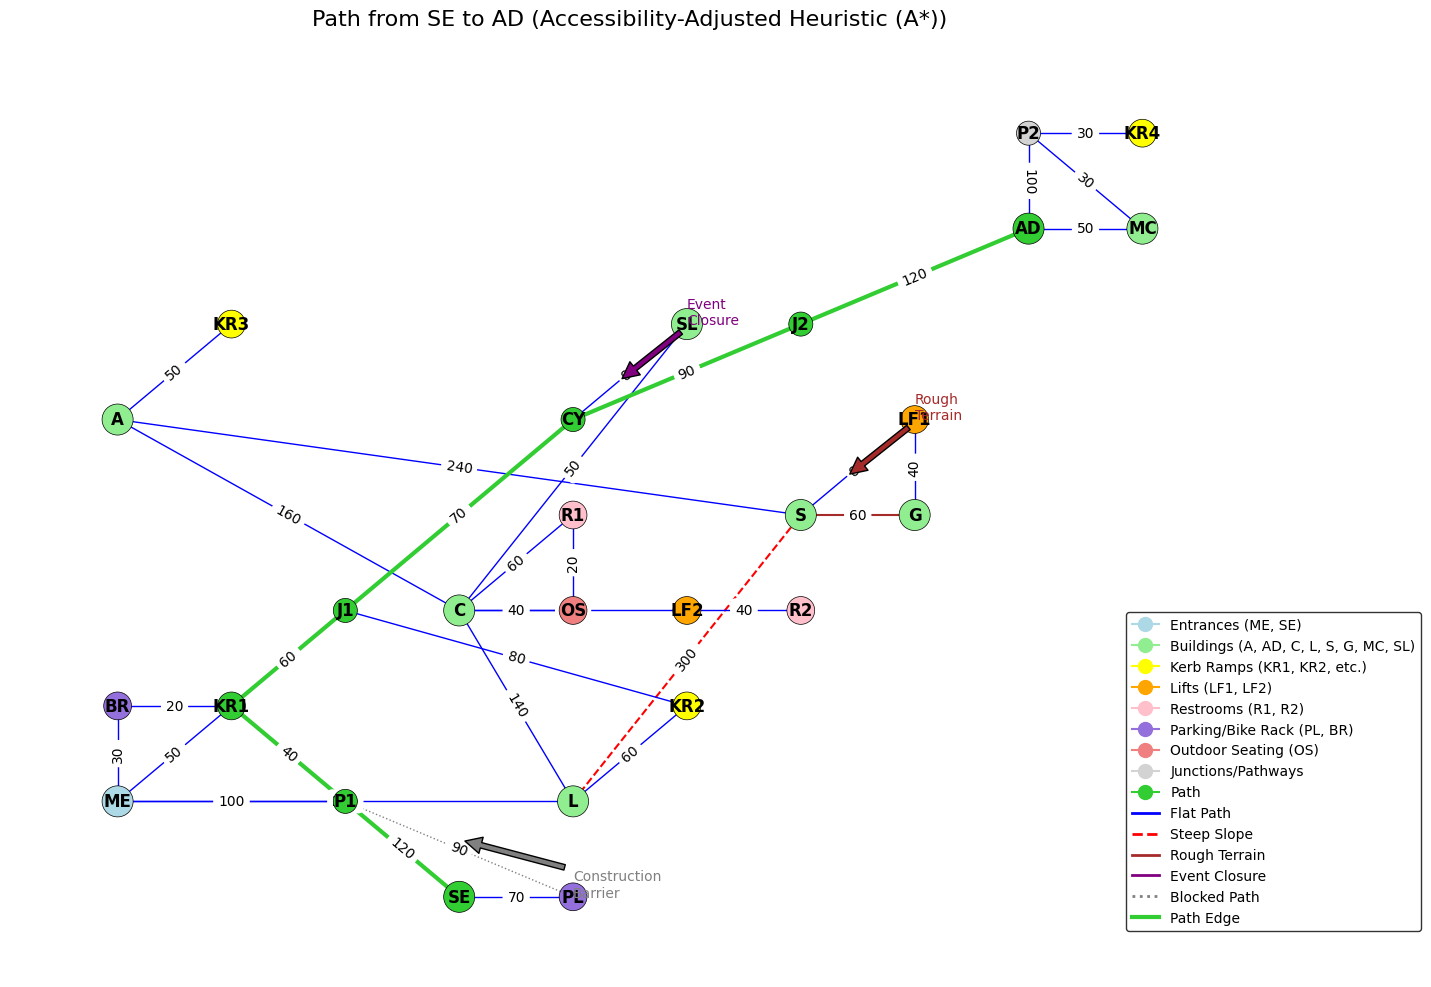

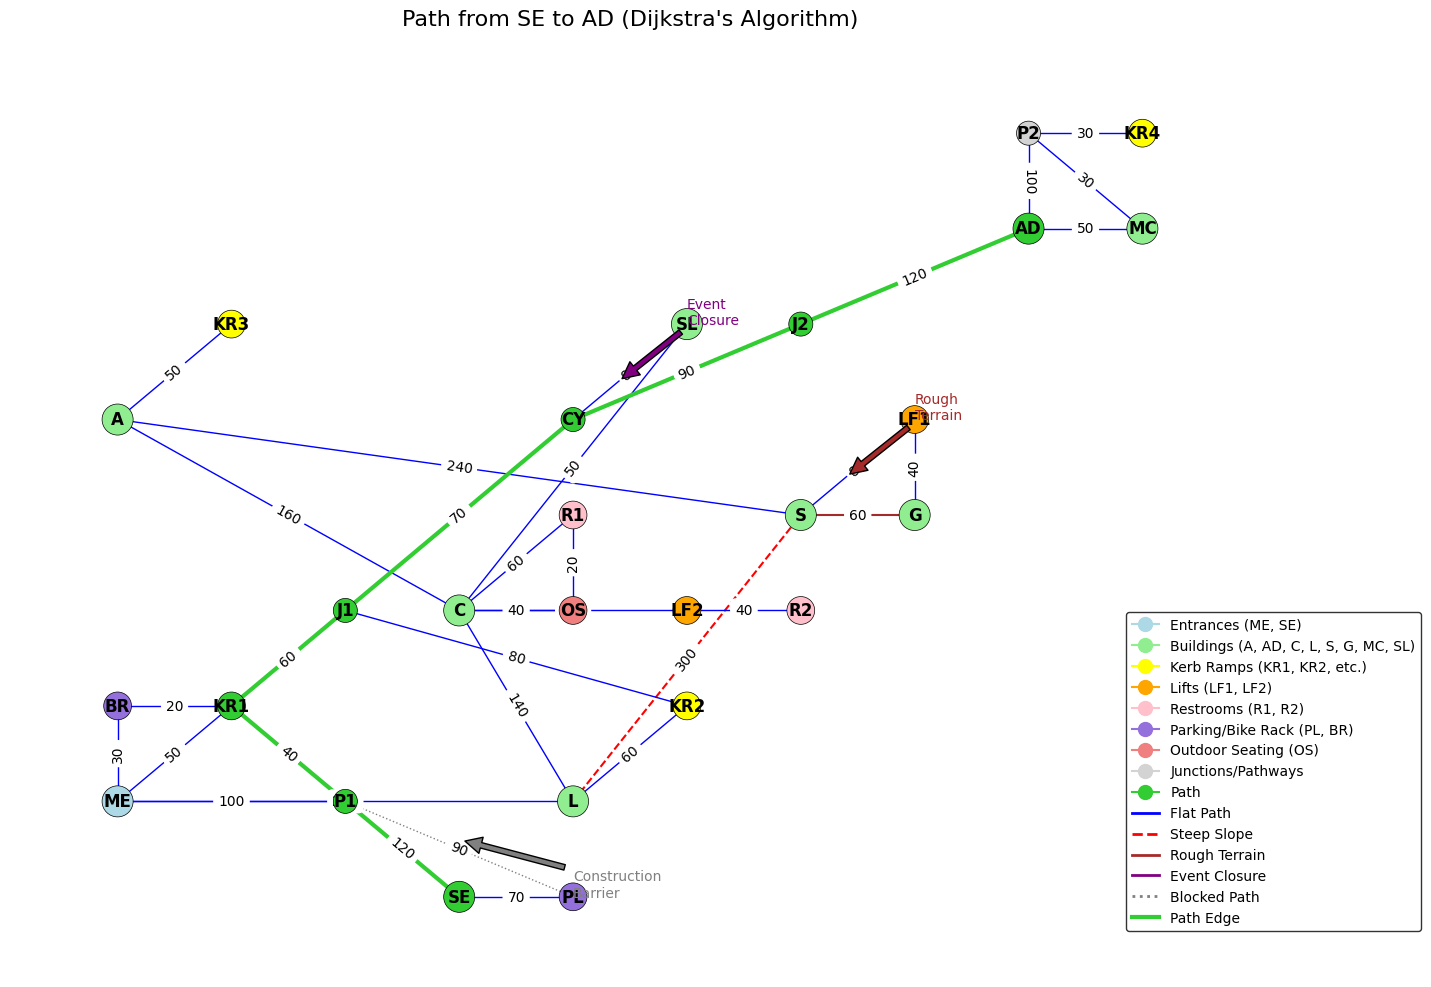

In [20]:



import time  # Imports the 'time' module for measuring execution time

def run_comparison(graph, graph_data):
    """
    Runs a comparison of three pathfinding algorithms: A* with Euclidean heuristic,
    A* with accessibility-adjusted heuristic, and Dijkstra's algorithm.

    Args:
        graph (Graph): The graph representing the map.
        graph_data (dict): Data for visualizing the graph.

    Returns:
        list: A list of dictionaries containing results for each test case.
    """
    test_cases = [
        ('ME', 'R1', False),  # Test case 1: Main Entrance to Restroom 1, no event
        ('A', 'LF1', False),  # Test case 2: Admin Building to Lift 1, no event
        ('SE', 'AD', True)   # Test case 3: Side Entrance to Academic Department, event time
    ]

    results = []  # List to store results for each test case

    # Iterate through each test case
    for start, end, is_event_time in test_cases:
        print(f"\n=== Test Case: {start} to {end} (Event Time: {is_event_time}) ===")  # Print test case header

        # --- Euclidean heuristic (A*) ---
        problem = WheelchairProblem(start, end, graph)  # Create a problem instance for the current test case
        start_time = time.time()  # Record the start time
        result_euclidean = a_star_search(problem, use_accessibility_heuristic=False, is_event_time=is_event_time)  # Run A* with Euclidean heuristic
        time_euclidean = time.time() - start_time  # Calculate execution time

        # Store results if a path is found
        if result_euclidean:
            path_euclidean = [node.state for node in result_euclidean.path()]  # Extract the path (list of node states)
            cost_euclidean = result_euclidean.path_cost  # Get the total path cost
            nodes_explored_euclidean = len([node for node in problem.graph.nodes() if node in path_euclidean or node in problem.graph.nodes()]) # Calculate the number of explored nodes (approximation)
        else:
            # Handle case where no path is found
            path_euclidean = []  # Empty path
            cost_euclidean = float('inf')  # Infinite cost
            nodes_explored_euclidean = 0  # No nodes explored
            print(f"Euclidean Heuristic: No path found from {start} to {end} (Event Time: {is_event_time})")  # Print message

        # --- Accessibility-adjusted heuristic (A*) ---
        start_time = time.time()  # Record the start time
        result_accessibility = a_star_search(problem, use_accessibility_heuristic=True, is_event_time=is_event_time)  # Run A* with accessibility heuristic
        time_accessibility = time.time() - start_time  # Calculate execution time

        # Store results if a path is found
        if result_accessibility:
            path_accessibility = [node.state for node in result_accessibility.path()]  # Extract the path
            cost_accessibility = result_accessibility.path_cost  # Get the total path cost
            nodes_explored_accessibility = len([node for node in problem.graph.nodes() if node in path_accessibility or node in problem.graph.nodes()])  # Calculate explored nodes (approximation)

        else:
            # Handle case where no path is found
            path_accessibility = []  # Empty path
            cost_accessibility = float('inf')  # Infinite cost
            nodes_explored_accessibility = 0  # No nodes explored
            print(f"Accessibility-Adjusted Heuristic: No path found from {start} to {end} (Event Time: {is_event_time})")  # Print message

        # --- Dijkstra's Algorithm ---
        start_time = time.time()  # Record the start time
        result_dijkstra = dijkstra_search(problem, is_event_time=is_event_time)  # Run Dijkstra's algorithm
        time_dijkstra = time.time() - start_time  # Calculate execution time

        # Store results if a path is found
        if result_dijkstra:
            path_dijkstra = [node.state for node in result_dijkstra]  # Extract the path
            cost_dijkstra = sum(problem.path_cost(0, path_dijkstra[i], None, path_dijkstra[i + 1], is_event_time) for i in range(len(path_dijkstra) - 1))  # Calculate total path cost
            nodes_explored_dijkstra = len([node for node in problem.graph.nodes() if node in path_dijkstra or node in problem.graph.nodes()]) # Calculate explored nodes (approximation)
        else:
            # Handle case where no path is found
            path_dijkstra = []  # Empty path
            cost_dijkstra = float('inf')  # Infinite cost
            nodes_explored_dijkstra = 0  # No nodes explored
            print(f"Dijkstra's Algorithm: No path found from {start} to {end} (Event Time: {is_event_time})")  # Print message

        # Store results for the current test case in the 'results' list
        results.append({
            'start': start, 'end': end, 'is_event_time': is_event_time,
            'path_euclidean': path_euclidean, 'cost_euclidean': cost_euclidean, 'time_euclidean': time_euclidean, 'nodes_explored_euclidean': nodes_explored_euclidean,
            'path_accessibility': path_accessibility, 'cost_accessibility': cost_accessibility, 'time_accessibility': time_accessibility, 'nodes_explored_accessibility': nodes_explored_accessibility,
            'path_dijkstra': path_dijkstra, 'cost_dijkstra': cost_dijkstra, 'time_dijkstra': time_dijkstra, 'nodes_explored_dijkstra': nodes_explored_dijkstra
        })

        # Print results for the current test case
        print("Euclidean Heuristic (A*) Path:", path_euclidean)
        print("Euclidean Heuristic (A*) Cost:", cost_euclidean)
        print("Euclidean Heuristic (A*) Time:", time_euclidean, "seconds")
        print("Euclidean Heuristic (A*) Nodes Explored:", nodes_explored_euclidean)

        print("Accessibility-Adjusted Heuristic (A*) Path:", path_accessibility)
        print("Accessibility-Adjusted Heuristic (A*) Cost:", cost_accessibility)
        print("Accessibility-Adjusted Heuristic (A*) Time:", time_accessibility, "seconds")
        print("Accessibility-Adjusted Heuristic (A*) Nodes Explored:", nodes_explored_accessibility)

        print("Dijkstra's Algorithm Path:", path_dijkstra)
        print("Dijkstra's Algorithm Cost:", cost_dijkstra)
        print("Dijkstra's Algorithm Time:", time_dijkstra, "seconds")
        print("Dijkstra's Algorithm Nodes Explored:", nodes_explored_dijkstra)

        # Visualize paths (only if a path exists)
        if path_euclidean:
            show_path(graph_data, [Node(state) for state in path_euclidean], start, end, "Euclidean Heuristic (A*)")
        if path_accessibility:
            show_path(graph_data, [Node(state) for state in path_accessibility], start, end, "Accessibility-Adjusted Heuristic (A*)")
        if path_dijkstra:
            show_path(graph_data, [Node(state) for state in path_dijkstra], start, end, "Dijkstra's Algorithm")

    return results  # Return the list of results for all test cases

# Run the comparison using the wheelchair_map and wheelchair_graph_data
results = run_comparison(wheelchair_map, wheelchair_graph_data)

In [32]:
# If needed, install ipywidgets in Colab:
# !pip install ipywidgets
# and enable widgets for Jupyter:
# !jupyter nbextension enable --py widgetsnbextension

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def colab_gui_navigation():
    # === 1. Create input widgets ===
    start_node = widgets.Text(
        value='ME',
        description='Start:',
        layout=widgets.Layout(width='150px')
    )
    end_node = widgets.Text(
        value='R1',
        description='End:',
        layout=widgets.Layout(width='150px')
    )

    event_time = widgets.Checkbox(
        value=False,
        description='Event Conditions',
        indent=False
    )

    # Algorithm selection: A* or Dijkstra
    algo_options = [
        ('A* Search (Euclidean)', 'a_star_eu'),
        ('A* Search (Accessibility)', 'a_star_acc'),
        ('Dijkstra’s Algorithm', 'dijkstra')
    ]
    algo_select = widgets.Dropdown(
        options=algo_options,
        value='a_star_eu',
        description='Algorithm:'
    )

    # Button to run the search
    run_button = widgets.Button(description='Compute Path')

    # Output area to display text results
    output_area = widgets.Output(layout={'border': '1px solid black'})

    # === 2. Define the callback function ===
    def on_run_button_clicked(b):
        with output_area:
            clear_output()  # Clear previous results
            start = start_node.value.strip()
            end = end_node.value.strip()
            is_event = event_time.value

            if not start or not end:
                print("Please provide valid Start and End nodes.")
                return

            # Create the problem instance
            problem = WheelchairProblem(start, end, wheelchair_map)

            # Decide which algorithm/heuristic to run
            import time
            t0 = time.perf_counter()

            if algo_select.value == 'a_star_eu':
                # A* with Euclidean
                result = a_star_search(problem, use_accessibility_heuristic=False, is_event_time=is_event)
                method = "A* (Euclidean)"
            elif algo_select.value == 'a_star_acc':
                # A* with accessibility
                result = a_star_search(problem, use_accessibility_heuristic=True, is_event_time=is_event)
                method = "A* (Accessibility)"
            else:
                # Dijkstra
                result = dijkstra_search(problem, is_event_time=is_event)
                method = "Dijkstra"

            elapsed = (time.perf_counter() - t0) * 1000  # ms

            if result:
                path_list = [node.state for node in result.path()]
                path_str = " -> ".join(path_list)
                print(f"Algorithm: {method}")
                print(f"Start: {start}, End: {end}")
                print(f"Event Conditions: {is_event}")
                print(f"Path Found: {path_str}")
                print(f"Path Cost: {result.path_cost}")
                print(f"Execution Time: {elapsed:.2f} ms")

                # Visualize with show_path (matplotlib inline)
                show_path(
                    wheelchair_graph_data,
                    result.path(),
                    start_node=start,
                    end_node=end,
                    heuristic_name=method
                )
                plt.show()
            else:
                print(f"No valid path found from {start} to {end} using {method}.")

    run_button.on_click(on_run_button_clicked)

    # === 3. Arrange everything into a UI layout ===
    ui = widgets.VBox([
        widgets.HBox([start_node, end_node]),
        widgets.HBox([algo_select, event_time]),
        run_button,
        output_area
    ])

    display(ui)

# Finally, call this function in a cell to show the UI
colab_gui_navigation()


In [33]:
def unify_path_and_cost(result, problem=None):
    """
    Unify different return types from Dijkstra (list of Nodes) vs. A* (single Node).
    Returns (path_nodes, cost_val).

    - path_nodes: a list of Node objects in order from start to goal
    - cost_val:   the final path cost as a float
    """
    if result is None:
        return [], float('inf')  # No path found

    # If it's already a list (like your Dijkstra code might return):
    if isinstance(result, list):
        # 'result' is something like [Node1, Node2, ..., NodeGoal]
        path_nodes = result

        # cost might be stored in the final node's path_cost, if your Dijkstra sets it
        if len(result) > 0 and hasattr(result[-1], 'path_cost'):
            cost_val = result[-1].path_cost
        else:
            # If you don't store path_cost in the node,
            # you can recalc by summing edges or set a placeholder:
            cost_val = float('inf')
    else:
        # A* returns a single Node that has .path() and .path_cost
        path_nodes = result.path()  # list of Node objects
        cost_val = result.path_cost

    return path_nodes, cost_val


In [34]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def colab_gui_navigation(wheelchair_map, wheelchair_graph_data, WheelchairProblem,
                         a_star_search, dijkstra_search, show_path):
    """
    A Colab-friendly GUI for wheelchair navigation.
    Adapts to differences in return types from Dijkstra (list of Nodes) vs A* (single Node).
    """

    # 1) Text inputs for start/end
    start_node = widgets.Text(value='ME', description='Start:', layout=widgets.Layout(width='150px'))
    end_node   = widgets.Text(value='R1', description='End:', layout=widgets.Layout(width='150px'))

    # 2) Event time toggle
    event_time = widgets.Checkbox(value=False, description='Event Conditions', indent=False)

    # 3) Algorithm selection: A* (Euclidean), A* (Accessibility), Dijkstra
    algo_options = [
        ('A* Search (Euclidean)', 'a_star_eu'),
        ('A* Search (Accessibility)', 'a_star_acc'),
        ('Dijkstra’s Algorithm', 'dijkstra')
    ]
    algo_select = widgets.Dropdown(options=algo_options, value='a_star_eu', description='Algorithm:')

    # 4) "Compute Path" button
    run_button = widgets.Button(description='Compute Path')

    # 5) Output area for text results
    output_area = widgets.Output(layout={'border': '1px solid black'})

    # Helper from earlier to unify path cost
    def unify_path_and_cost(result):
        if result is None:
            return [], float('inf')
        if isinstance(result, list):
            # Dijkstra result
            path_nodes = result
            if len(result) > 0 and hasattr(result[-1], 'path_cost'):
                cost_val = result[-1].path_cost
            else:
                cost_val = float('inf')
        else:
            # A* result (single Node)
            path_nodes = result.path()
            cost_val   = result.path_cost
        return path_nodes, cost_val

    # Callback
    def on_run_button_clicked(b):
        with output_area:
            clear_output()
            start = start_node.value.strip()
            end   = end_node.value.strip()
            if not start or not end:
                print("Please enter valid Start and End nodes.")
                return

            # Build the problem
            problem = WheelchairProblem(start, end, wheelchair_map)
            is_event = event_time.value

            # Decide which algorithm
            import time
            t0 = time.perf_counter()
            if algo_select.value == 'a_star_eu':
                result = a_star_search(problem, use_accessibility_heuristic=False, is_event_time=is_event)
                method = "A* (Euclidean)"
            elif algo_select.value == 'a_star_acc':
                result = a_star_search(problem, use_accessibility_heuristic=True, is_event_time=is_event)
                method = "A* (Accessibility)"
            else:
                result = dijkstra_search(problem, is_event_time=is_event)
                method = "Dijkstra"

            elapsed = (time.perf_counter() - t0)*1000

            # Unify the path & cost
            path_nodes, cost_val = unify_path_and_cost(result)

            if not path_nodes or cost_val == float('inf'):
                # No path or infinite cost
                print(f"No valid path found from {start} to {end} using {method}.")
                return

            # Construct a path string for display
            path_str = " -> ".join(n.state for n in path_nodes)
            print(f"Algorithm: {method}")
            print(f"Start: {start}, End: {end}")
            print(f"Event Conditions: {is_event}")
            print(f"Path Found: {path_str}")
            print(f"Path Cost: {cost_val}")
            print(f"Execution Time: {elapsed:.2f} ms")

            # Show with show_path (matplotlib)
            show_path(
                wheelchair_graph_data,
                path_nodes,  # a list of Node objects
                start_node=start,
                end_node=end,
                heuristic_name=method
            )
            plt.show()

    run_button.on_click(on_run_button_clicked)

    # Layout
    ui = widgets.VBox([
        widgets.HBox([start_node, end_node]),
        widgets.HBox([algo_select, event_time]),
        run_button,
        output_area
    ])
    display(ui)


In [35]:
colab_gui_navigation(
    wheelchair_map,
    wheelchair_graph_data,
    WheelchairProblem,
    a_star_search,
    dijkstra_search,
    show_path
)
